# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 8  
data_points_exp = 30000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 8]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 2034.8565673828125
iteration 0 loss 82.29446411132812


iteration 500 loss 0.8962035775184631


iteration 1000 loss 0.4317401051521301


iteration 1500 loss 0.2596531808376312


iteration 2000 loss 0.17867423593997955


iteration 2500 loss 0.4713013768196106


iteration 3000 loss 0.1340607851743698


iteration 3500 loss 0.10617461800575256


iteration 4000 loss 0.0876183733344078


iteration 4500 loss 0.148397296667099


iteration 5000 loss 0.09181076288223267


iteration 5500 loss 0.07481170445680618


iteration 6000 loss 0.06459124386310577


iteration 6500 loss 0.49060961604118347


iteration 7000 loss 0.05659782886505127


iteration 7500 loss 0.04973331093788147


iteration 8000 loss 0.04897208884358406


iteration 8500 loss 0.05449702963232994


iteration 9000 loss 0.0423598438501358


iteration 9500 loss 0.04151737689971924


iteration 10000 loss 0.04320644959807396


iteration 10500 loss 0.03641810640692711


iteration 11000 loss 0.03552253916859627


iteration 11500 loss 0.03456274792551994


iteration 12000 loss 0.03365462273359299


iteration 12500 loss 0.03312157467007637


iteration 13000 loss 0.033885300159454346


iteration 13500 loss 0.22370924055576324


iteration 14000 loss 0.2285892814397812


iteration 14500 loss 0.026142848655581474


iteration 15000 loss 0.025376969948410988


iteration 15500 loss 0.024641288444399834


iteration 16000 loss 0.024009542539715767


iteration 16500 loss 5.176509380340576


iteration 17000 loss 0.21099501848220825


iteration 17500 loss 0.07045768201351166


iteration 18000 loss 0.027674702927470207


iteration 18500 loss 0.03299148753285408


iteration 19000 loss 0.030123423784971237


iteration 19500 loss 0.01939358562231064


iteration 20000 loss 0.01897425577044487


iteration 20500 loss 0.018533654510974884


iteration 21000 loss 0.01803566887974739


iteration 21500 loss 0.017547540366649628


iteration 22000 loss 0.017728136852383614


iteration 22500 loss 0.6485031843185425


iteration 23000 loss 0.027126140892505646


iteration 23500 loss 0.020274924114346504


iteration 24000 loss 0.01677391305565834


iteration 24500 loss 0.016235530376434326


iteration 25000 loss 0.01570291444659233


iteration 25500 loss 0.015340641140937805


iteration 26000 loss 0.014939194545149803


iteration 26500 loss 0.014445194974541664


iteration 27000 loss 0.013978247530758381


iteration 27500 loss 0.013562274165451527


iteration 28000 loss 0.10731567442417145


iteration 28500 loss 0.013737823814153671


iteration 29000 loss 0.013235844671726227


iteration 29500 loss 0.012889781035482883


iteration 30000 loss 0.012488774955272675


iteration 30500 loss 0.012169675901532173


iteration 31000 loss 0.2953871190547943


iteration 31500 loss 0.012379626743495464


iteration 32000 loss 0.011903875507414341


iteration 32500 loss 0.011523967608809471


iteration 33000 loss 0.011130989529192448


iteration 33500 loss 0.015348539687693119


iteration 34000 loss 0.011135510168969631


iteration 34500 loss 0.010713119991123676


iteration 35000 loss 0.04778150096535683


iteration 35500 loss 0.011107802391052246


iteration 36000 loss 0.010436637327075005


iteration 36500 loss 0.010037945583462715


iteration 37000 loss 0.009733869694173336


iteration 37500 loss 0.010379687882959843


iteration 38000 loss 0.0098010478541255


iteration 38500 loss 0.009489369578659534


iteration 39000 loss 0.009207773953676224


iteration 39500 loss 0.08941158652305603


iteration 40000 loss 0.009255776181817055


iteration 40500 loss 0.008897813968360424


iteration 41000 loss 0.00863446481525898


iteration 41500 loss 0.009317654184997082


iteration 42000 loss 0.008675482124090195


iteration 42500 loss 0.008381232619285583


iteration 43000 loss 0.008171210065484047


iteration 43500 loss 0.00916636548936367


iteration 44000 loss 0.008291597478091717


iteration 44500 loss 0.008101816289126873


iteration 45000 loss 0.007846647873520851


iteration 45500 loss 0.6002880334854126


iteration 46000 loss 0.007959935814142227


iteration 46500 loss 0.007705622352659702


iteration 47000 loss 0.007455198559910059


iteration 47500 loss 0.09108030796051025


iteration 48000 loss 0.0073635028675198555


iteration 48500 loss 0.007134491577744484


iteration 49000 loss 0.016382336616516113


iteration 49500 loss 0.007194363512098789


iteration 50000 loss 0.0069372872821986675


iteration 50500 loss 0.05575775355100632


iteration 51000 loss 0.006720661651343107


iteration 51500 loss 0.013259434141218662


iteration 52000 loss 0.006831936538219452


iteration 52500 loss 0.006517949514091015


iteration 53000 loss 0.007311956956982613


iteration 53500 loss 0.006411253474652767


iteration 54000 loss 0.021210476756095886


iteration 54500 loss 0.006346297450363636


iteration 55000 loss 0.0061586108058691025


iteration 55500 loss 0.0062871892005205154


iteration 56000 loss 0.006056173704564571


iteration 56500 loss 0.006397807504981756


iteration 57000 loss 0.006223433651030064


iteration 57500 loss 0.0058638122864067554


iteration 58000 loss 0.006163647398352623


iteration 58500 loss 0.0058909086510539055


iteration 59000 loss 0.006010540761053562


iteration 59500 loss 0.0056566642597317696


iteration 60000 loss 0.005997020751237869


iteration 60500 loss 0.0056105926632881165


iteration 61000 loss 0.005706641357392073


iteration 61500 loss 1.3331891298294067


iteration 62000 loss 0.005572582595050335


iteration 62500 loss 0.005367079749703407


iteration 63000 loss 0.18443499505519867


iteration 63500 loss 0.005397834815084934


iteration 64000 loss 0.005405415780842304


iteration 64500 loss 0.0051946514286100864


iteration 65000 loss 0.00558851333335042


iteration 65500 loss 0.005091204773634672


iteration 66000 loss 0.005322945304214954


iteration 66500 loss 0.005057690665125847


iteration 67000 loss 0.005063760560005903


iteration 67500 loss 0.019370947033166885


iteration 68000 loss 0.004902661312371492


iteration 68500 loss 0.005228081718087196


iteration 69000 loss 0.00490922573953867


iteration 69500 loss 0.00478060869500041


iteration 70000 loss 0.008076648227870464


iteration 70500 loss 0.004798621870577335


iteration 71000 loss 0.027034344151616096


iteration 71500 loss 0.004863062407821417


iteration 72000 loss 0.004642520099878311


iteration 72500 loss 0.004778679925948381


iteration 73000 loss 0.004850332625210285


iteration 73500 loss 0.004537523258477449


iteration 74000 loss 0.004699429497122765


iteration 74500 loss 0.43641015887260437


iteration 75000 loss 0.005764456931501627


iteration 75500 loss 0.004749364219605923


iteration 76000 loss 0.005978173576295376


iteration 76500 loss 0.004536733031272888


iteration 77000 loss 0.005918087437748909


iteration 77500 loss 0.004374136216938496


iteration 78000 loss 0.009097154252231121


iteration 78500 loss 0.09733911603689194


iteration 79000 loss 0.005552188493311405


iteration 79500 loss 0.004259300418198109


iteration 80000 loss 0.004400195553898811


iteration 80500 loss 0.004287689924240112


iteration 81000 loss 0.0055616009049117565


iteration 81500 loss 0.0041946349665522575


iteration 82000 loss 0.015641668811440468


iteration 82500 loss 0.004859043285250664


iteration 83000 loss 0.004410676192492247


iteration 83500 loss 0.004089872818440199


iteration 84000 loss 0.004123827442526817


iteration 84500 loss 0.006000788416713476


iteration 85000 loss 0.006196333095431328


iteration 85500 loss 0.004310160409659147


iteration 86000 loss 0.004023256711661816


iteration 86500 loss 0.004905931185930967


iteration 87000 loss 0.011890583671629429


iteration 87500 loss 0.0039947135373950005


iteration 88000 loss 0.004526454024016857


iteration 88500 loss 0.0041886246763169765


iteration 89000 loss 0.0038398290053009987


iteration 89500 loss 0.003972523845732212


iteration 90000 loss 0.0038338431622833014


iteration 90500 loss 0.003930884413421154


iteration 91000 loss 0.003810897469520569


iteration 91500 loss 0.0038452392909675837


iteration 92000 loss 0.003807632951065898


iteration 92500 loss 0.003794434480369091


iteration 93000 loss 0.003789048409089446


iteration 93500 loss 0.004998463671654463


iteration 94000 loss 0.025364462286233902


iteration 94500 loss 0.0067755309864878654


iteration 95000 loss 0.0036696463357657194


iteration 95500 loss 0.35731855034828186


iteration 96000 loss 0.003752428339794278


iteration 96500 loss 0.0036668358370661736


iteration 97000 loss 0.0112036457285285


iteration 97500 loss 0.0036751986481249332


iteration 98000 loss 0.0036168680526316166


iteration 98500 loss 0.0036383133847266436


iteration 99000 loss 0.0037037197034806013


iteration 99500 loss 0.00368930003605783


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.011360027827322483


iteration 100500 loss 0.003495208453387022


iteration 101000 loss 0.0034568666014820337


iteration 101500 loss 0.0034136336762458086


iteration 102000 loss 0.0033653758000582457


iteration 102500 loss 0.003312014741823077


iteration 103000 loss 0.0032533418852835894


iteration 103500 loss 0.003189229406416416


iteration 104000 loss 0.0031194924376904964


iteration 104500 loss 0.0030440634582191706


iteration 105000 loss 0.0029841181822121143


iteration 105500 loss 0.002928003901615739


iteration 106000 loss 0.0028755676466971636


iteration 106500 loss 0.0028285349253565073


iteration 107000 loss 0.0027854873333126307


iteration 107500 loss 0.0027468474581837654


iteration 108000 loss 0.032812558114528656


iteration 108500 loss 0.0026774369180202484


iteration 109000 loss 0.0026443253736943007


iteration 109500 loss 0.002614462748169899


iteration 110000 loss 0.002585016656666994


iteration 110500 loss 0.002559770131483674


iteration 111000 loss 0.0025346146430820227


iteration 111500 loss 0.0025104477535933256


iteration 112000 loss 0.003560206852853298


iteration 112500 loss 0.05570761859416962


iteration 113000 loss 0.0024417852982878685


iteration 113500 loss 0.0024188964162021875


iteration 114000 loss 0.002398921176791191


iteration 114500 loss 0.0023805664386600256


iteration 115000 loss 0.002798475092276931


iteration 115500 loss 0.00236755283549428


iteration 116000 loss 0.002323623513802886


iteration 116500 loss 0.0023060704115778208


iteration 117000 loss 0.0022880060132592916


iteration 117500 loss 0.0022724734153598547


iteration 118000 loss 0.0022560704965144396


iteration 118500 loss 0.0022406522184610367


iteration 119000 loss 0.0022720983251929283


iteration 119500 loss 0.0022099283523857594


iteration 120000 loss 0.0021948721259832382


iteration 120500 loss 0.002181396586820483


iteration 121000 loss 0.0021676348987966776


iteration 121500 loss 0.002154691144824028


iteration 122000 loss 0.0021413371432572603


iteration 122500 loss 0.002127815270796418


iteration 123000 loss 0.0021155434660613537


iteration 123500 loss 0.0021020364947617054


iteration 124000 loss 0.00209184386767447


iteration 124500 loss 0.002080263802781701


iteration 125000 loss 0.0020691531244665384


iteration 125500 loss 0.002058033598586917


iteration 126000 loss 0.002045419765636325


iteration 126500 loss 0.0020379272755235434


iteration 127000 loss 0.0020227006170898676


iteration 127500 loss 0.0020117147359997034


iteration 128000 loss 0.0020015158224850893


iteration 128500 loss 0.0019908612594008446


iteration 129000 loss 0.0019806011114269495


iteration 129500 loss 0.001973185921087861


iteration 130000 loss 0.0019599199295043945


iteration 130500 loss 0.022287771105766296


iteration 131000 loss 0.0024536983110010624


iteration 131500 loss 0.0019294361118227243


iteration 132000 loss 0.0019299340201541781


iteration 132500 loss 0.0019099557539448142


iteration 133000 loss 0.0019002776825800538


iteration 133500 loss 0.0018910998478531837


iteration 134000 loss 0.0019003296038135886


iteration 134500 loss 0.0018723373068496585


iteration 135000 loss 0.0018637703033164144


iteration 135500 loss 0.0018546551000326872


iteration 136000 loss 0.001845856779254973


iteration 136500 loss 0.0018381879199296236


iteration 137000 loss 0.0018297439673915505


iteration 137500 loss 0.001821581507101655


iteration 138000 loss 0.0018134054262191057


iteration 138500 loss 0.0018050821963697672


iteration 139000 loss 0.0018638984765857458


iteration 139500 loss 0.0018079294823110104


iteration 140000 loss 0.0017807706026360393


iteration 140500 loss 0.0017729831160977483


iteration 141000 loss 0.0017651752568781376


iteration 141500 loss 0.0017582245636731386


iteration 142000 loss 0.0017594530945643783


iteration 142500 loss 0.001744417124427855


iteration 143000 loss 0.001736933714710176


iteration 143500 loss 0.0017296788282692432


iteration 144000 loss 0.0017232574755325913


iteration 144500 loss 0.0017159284325316548


iteration 145000 loss 0.0017104067374020815


iteration 145500 loss 0.0017039355589076877


iteration 146000 loss 0.0016998974606394768


iteration 146500 loss 0.0016921680653467774


iteration 147000 loss 0.0032398938201367855


iteration 147500 loss 0.0016791061498224735


iteration 148000 loss 0.001671999110840261


iteration 148500 loss 0.0016666381852701306


iteration 149000 loss 0.0016612469917163253


iteration 149500 loss 0.0016999169019982219


iteration 150000 loss 0.0016510185087099671


iteration 150500 loss 0.0016419471940025687


iteration 151000 loss 0.0016348850913345814


iteration 151500 loss 0.001628697500564158


iteration 152000 loss 0.002786366268992424


iteration 152500 loss 0.0016170485178008676


iteration 153000 loss 0.0016115575563162565


iteration 153500 loss 0.00160870177205652


iteration 154000 loss 0.004559951834380627


iteration 154500 loss 0.0015940130688250065


iteration 155000 loss 0.001588308485224843


iteration 155500 loss 0.0015828529139980674


iteration 156000 loss 0.0015771739417687058


iteration 156500 loss 0.001571323024109006


iteration 157000 loss 0.0015664830571040511


iteration 157500 loss 0.0015613447176292539


iteration 158000 loss 0.0029923166148364544


iteration 158500 loss 0.0015599285252392292


iteration 159000 loss 0.0015471639344468713


iteration 159500 loss 0.0015402777353301644


iteration 160000 loss 0.001534768263809383


iteration 160500 loss 0.0015295130433514714


iteration 161000 loss 0.0015245173126459122


iteration 161500 loss 0.001548338565044105


iteration 162000 loss 0.0015176109736785293


iteration 162500 loss 0.001509234425611794


iteration 163000 loss 0.001504038111306727


iteration 163500 loss 0.0014999661361798644


iteration 164000 loss 0.001544300583191216


iteration 164500 loss 0.0014932604972273111


iteration 165000 loss 0.0014859420480206609


iteration 165500 loss 0.0014817863702774048


iteration 166000 loss 0.0014769253320991993


iteration 166500 loss 0.0014724022476002574


iteration 167000 loss 0.0014681582106277347


iteration 167500 loss 0.0014632489765062928


iteration 168000 loss 0.0014596456894651055


iteration 168500 loss 0.0014559293631464243


iteration 169000 loss 0.0014504690188914537


iteration 169500 loss 0.0014462050748988986


iteration 170000 loss 0.0014419013168662786


iteration 170500 loss 0.0014373367885127664


iteration 171000 loss 0.0014331223210319877


iteration 171500 loss 0.0014294126303866506


iteration 172000 loss 0.0014324045041576028


iteration 172500 loss 0.0014209680957719684


iteration 173000 loss 0.0014257949078455567


iteration 173500 loss 0.0022336337715387344


iteration 174000 loss 0.0014085116563364863


iteration 174500 loss 0.0014042967231944203


iteration 175000 loss 0.006556943990290165


iteration 175500 loss 0.0013963899109512568


iteration 176000 loss 0.0013920634519308805


iteration 176500 loss 0.0013884371146559715


iteration 177000 loss 0.0013840905157849193


iteration 177500 loss 0.0013804499758407474


iteration 178000 loss 0.0013794436817988753


iteration 178500 loss 0.001373017206788063


iteration 179000 loss 0.0013689707266166806


iteration 179500 loss 0.001366118434816599


iteration 180000 loss 0.0013622855767607689


iteration 180500 loss 0.001358273671939969


iteration 181000 loss 0.0013548436108976603


iteration 181500 loss 0.0013514913152903318


iteration 182000 loss 0.0013473940780386329


iteration 182500 loss 0.0013444558717310429


iteration 183000 loss 0.0013421948533505201


iteration 183500 loss 0.0013374590780586004


iteration 184000 loss 0.0013342922320589423


iteration 184500 loss 0.00133036682382226


iteration 185000 loss 0.0013272337382659316


iteration 185500 loss 0.0013626060681417584


iteration 186000 loss 0.0013200582470744848


iteration 186500 loss 0.0013172065373510122


iteration 187000 loss 0.002255380852147937


iteration 187500 loss 0.0016874029533937573


iteration 188000 loss 0.001314968685619533


iteration 188500 loss 0.0013044908409938216


iteration 189000 loss 0.0012999690370634198


iteration 189500 loss 0.0013022107305005193


iteration 190000 loss 0.0012932941317558289


iteration 190500 loss 0.0012898963177576661


iteration 191000 loss 0.001286826329305768


iteration 191500 loss 0.001283840974792838


iteration 192000 loss 0.0012803464196622372


iteration 192500 loss 0.0012771665351465344


iteration 193000 loss 0.0012737833894789219


iteration 193500 loss 0.0012710681185126305


iteration 194000 loss 0.001268747728317976


iteration 194500 loss 0.001265311031602323


iteration 195000 loss 0.0012622129870578647


iteration 195500 loss 0.001259414479136467


iteration 196000 loss 0.0012559409951791167


iteration 196500 loss 0.0012534047709777951


iteration 197000 loss 0.001251550274901092


iteration 197500 loss 0.0012474395334720612


iteration 198000 loss 0.0012444992316886783


iteration 198500 loss 0.0012416476383805275


iteration 199000 loss 0.0012387672904878855


iteration 199500 loss 0.0012357528321444988


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.001232692738994956


iteration 200500 loss 0.0012323105474933982


iteration 201000 loss 0.0012318259105086327


iteration 201500 loss 0.0012312198523432016


iteration 202000 loss 0.0012304639676585793


iteration 202500 loss 0.0012295000487938523


iteration 203000 loss 0.0012282648822292686


iteration 203500 loss 0.0012266964185982943


iteration 204000 loss 0.0012246882542967796


iteration 204500 loss 0.001222121063619852


iteration 205000 loss 0.0012191100977361202


iteration 205500 loss 0.0012166433734819293


iteration 206000 loss 0.0012135424185544252


iteration 206500 loss 0.001211377326399088


iteration 207000 loss 0.001209016889333725


iteration 207500 loss 0.001206003944389522


iteration 208000 loss 0.0012038236018270254


iteration 208500 loss 0.0012015373213216662


iteration 209000 loss 0.0011986172758042812


iteration 209500 loss 0.0011962989810854197


iteration 210000 loss 0.0011934860376641154


iteration 210500 loss 0.0011911765905097127


iteration 211000 loss 0.0011886802967637777


iteration 211500 loss 0.0011859985534101725


iteration 212000 loss 0.001184001681394875


iteration 212500 loss 0.0011809386778622866


iteration 213000 loss 0.001180630293674767


iteration 213500 loss 0.0011759258341044188


iteration 214000 loss 0.0011731262784451246


iteration 214500 loss 0.0011710642138496041


iteration 215000 loss 0.0011686583748087287


iteration 215500 loss 0.0011661446187645197


iteration 216000 loss 0.0011636451818048954


iteration 216500 loss 0.0011612818343564868


iteration 217000 loss 0.0011587812332436442


iteration 217500 loss 0.0011563593288883567


iteration 218000 loss 0.001256882562302053


iteration 218500 loss 0.001151809934526682


iteration 219000 loss 0.001149659277871251


iteration 219500 loss 0.0011473082704469562


iteration 220000 loss 0.001145076472312212


iteration 220500 loss 0.0011425468837842345


iteration 221000 loss 0.0011404501274228096


iteration 221500 loss 0.0011383467353880405


iteration 222000 loss 0.0011358462506905198


iteration 222500 loss 0.001133911544457078


iteration 223000 loss 0.0011314491275697947


iteration 223500 loss 0.0011293675052002072


iteration 224000 loss 0.0011268546804785728


iteration 224500 loss 0.0011249454692006111


iteration 225000 loss 0.001122763380408287


iteration 225500 loss 0.0011204442707821727


iteration 226000 loss 0.0011186309857293963


iteration 226500 loss 0.0011163157178089023


iteration 227000 loss 0.0011142721632495522


iteration 227500 loss 0.0011120615527033806


iteration 228000 loss 0.0011098835384473205


iteration 228500 loss 0.0011080334661528468


iteration 229000 loss 0.0011056725634261966


iteration 229500 loss 0.0011038292432203889


iteration 230000 loss 0.0011018798686563969


iteration 230500 loss 0.001099646557122469


iteration 231000 loss 0.0010976239573210478


iteration 231500 loss 0.001095394603908062


iteration 232000 loss 0.0010936378967016935


iteration 232500 loss 0.0010914078447967768


iteration 233000 loss 0.001089520868845284


iteration 233500 loss 0.0010874179424718022


iteration 234000 loss 0.0010854342253878713


iteration 234500 loss 0.0010835211724042892


iteration 235000 loss 0.001081359339877963


iteration 235500 loss 0.0010795077541843057


iteration 236000 loss 0.001084331190213561


iteration 236500 loss 0.001075579086318612


iteration 237000 loss 0.0010734652169048786


iteration 237500 loss 0.001071631209924817


iteration 238000 loss 0.0010696843964979053


iteration 238500 loss 0.0010676353704184294


iteration 239000 loss 0.0010660445550456643


iteration 239500 loss 0.0010640332475304604


iteration 240000 loss 0.0010622084373608232


iteration 240500 loss 0.0010604218114167452


iteration 241000 loss 0.0010583660332486033


iteration 241500 loss 0.0010564763797447085


iteration 242000 loss 0.0010545457480475307


iteration 242500 loss 0.001052657375112176


iteration 243000 loss 0.001050722785294056


iteration 243500 loss 0.0010488625848665833


iteration 244000 loss 0.0010468653636053205


iteration 244500 loss 0.0010449194815009832


iteration 245000 loss 0.0010430484544485807


iteration 245500 loss 0.001041207928210497


iteration 246000 loss 0.001039511407725513


iteration 246500 loss 0.0010376609861850739


iteration 247000 loss 0.0010359362931922078


iteration 247500 loss 0.0010339976288378239


iteration 248000 loss 0.0010323363821953535


iteration 248500 loss 0.0010306386975571513


iteration 249000 loss 0.0010287449695169926


iteration 249500 loss 0.0010270931525155902


iteration 250000 loss 0.0010252048959955573


iteration 250500 loss 0.0010236388770863414


iteration 251000 loss 0.001021673553623259


iteration 251500 loss 0.0010198885574936867


iteration 252000 loss 0.001018063398078084


iteration 252500 loss 0.0010167142609134316


iteration 253000 loss 0.0010150126181542873


iteration 253500 loss 0.0010131091112270951


iteration 254000 loss 0.001011769287288189


iteration 254500 loss 0.0010100970976054668


iteration 255000 loss 0.0010082764783874154


iteration 255500 loss 0.0010068978881463408


iteration 256000 loss 0.0010051500285044312


iteration 256500 loss 0.0010034890146926045


iteration 257000 loss 0.0010019135661423206


iteration 257500 loss 0.001000130781903863


iteration 258000 loss 0.0009985336801037192


iteration 258500 loss 0.0009967803489416838


iteration 259000 loss 0.0009952239925041795


iteration 259500 loss 0.000993478111922741


iteration 260000 loss 0.0009917622664943337


iteration 260500 loss 0.000990025233477354


iteration 261000 loss 0.0009884198661893606


iteration 261500 loss 0.0009870111243799329


iteration 262000 loss 0.0009852340444922447


iteration 262500 loss 0.0009838364785537124


iteration 263000 loss 0.00098240387160331


iteration 263500 loss 0.0009806373855099082


iteration 264000 loss 0.000979077653028071


iteration 264500 loss 0.0009773874189704657


iteration 265000 loss 0.0009760244865901768


iteration 265500 loss 0.0009835470700636506


iteration 266000 loss 0.0009727906435728073


iteration 266500 loss 0.0009711599559523165


iteration 267000 loss 0.0009694785112515092


iteration 267500 loss 0.0009680090588517487


iteration 268000 loss 0.0009663545060902834


iteration 268500 loss 0.0009648139239288867


iteration 269000 loss 0.0009632115252315998


iteration 269500 loss 0.0010466340463608503


iteration 270000 loss 0.0009602845530025661


iteration 270500 loss 0.0009589294786565006


iteration 271000 loss 0.0009572225390002131


iteration 271500 loss 0.0009559706668369472


iteration 272000 loss 0.0009543987107463181


iteration 272500 loss 0.0009529809467494488


iteration 273000 loss 0.0009515888523310423


iteration 273500 loss 0.0009499885491095483


iteration 274000 loss 0.0009486199705861509


iteration 274500 loss 0.0009477157145738602


iteration 275000 loss 0.0009456920088268816


iteration 275500 loss 0.0009440559661015868


iteration 276000 loss 0.0009427859913557768


iteration 276500 loss 0.0009412194485776126


iteration 277000 loss 0.0009398385300301015


iteration 277500 loss 0.0009478017454966903


iteration 278000 loss 0.0009369389154016972


iteration 278500 loss 0.0009352978668175638


iteration 279000 loss 0.0009341334225609899


iteration 279500 loss 0.0009327313746325672


iteration 280000 loss 0.0009312757756561041


iteration 280500 loss 0.0009298413642682135


iteration 281000 loss 0.0009284112602472305


iteration 281500 loss 0.0009271838353015482


iteration 282000 loss 0.0009256339981220663


iteration 282500 loss 0.0009243880049325526


iteration 283000 loss 0.0009228845010511577


iteration 283500 loss 0.0009216200560331345


iteration 284000 loss 0.0009204480447806418


iteration 284500 loss 0.0009189575794152915


iteration 285000 loss 0.0009176532621495426


iteration 285500 loss 0.0009196212631650269


iteration 286000 loss 0.0009149590623565018


iteration 286500 loss 0.0009135109139606357


iteration 287000 loss 0.000912247400265187


iteration 287500 loss 0.0009110229439102113


iteration 288000 loss 0.0014748983085155487


iteration 288500 loss 0.0009084168705157936


iteration 289000 loss 0.0009070792002603412


iteration 289500 loss 0.0009056589333340526


iteration 290000 loss 0.0009046730119735003


iteration 290500 loss 0.0009034485556185246


iteration 291000 loss 0.0009351013577543199


iteration 291500 loss 0.0009009165805764496


iteration 292000 loss 0.0008996274555101991


iteration 292500 loss 0.0008983134175650775


iteration 293000 loss 0.0008973280782811344


iteration 293500 loss 0.0008956896490417421


iteration 294000 loss 0.0008967909379862249


iteration 294500 loss 0.0008930274052545428


iteration 295000 loss 0.0008917103405110538


iteration 295500 loss 0.0008903034031391144


iteration 296000 loss 0.0008891739998944104


iteration 296500 loss 0.0008879258530214429


iteration 297000 loss 0.0008866469142958522


iteration 297500 loss 0.00088544498430565


iteration 298000 loss 0.0008841016096994281


iteration 298500 loss 0.0008829782018437982


iteration 299000 loss 0.0008897137013264


iteration 299500 loss 0.0008805142133496702


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.000880247273016721


iteration 300500 loss 0.0008790331776253879


iteration 301000 loss 0.0008788135601207614


iteration 301500 loss 0.0008785345708020031


iteration 302000 loss 0.0008781798533163965


iteration 302500 loss 0.0008777224575169384


iteration 303000 loss 0.0008771379943937063


iteration 303500 loss 0.0008763891528360546


iteration 304000 loss 0.0008754324517212808


iteration 304500 loss 0.0008742078789509833


iteration 305000 loss 0.0008728390093892813


iteration 305500 loss 0.000871879979968071


iteration 306000 loss 0.0008706574444659054


iteration 306500 loss 0.0008692896808497608


iteration 307000 loss 0.0008683362393639982


iteration 307500 loss 0.0008671117248013616


iteration 308000 loss 0.0008658116566948593


iteration 308500 loss 0.0008647980866953731


iteration 309000 loss 0.000863503897562623


iteration 309500 loss 0.0008623491739854217


iteration 310000 loss 0.0008612191886641085


iteration 310500 loss 0.0008599961292929947


iteration 311000 loss 0.0008589160861447453


iteration 311500 loss 0.0008577914559282362


iteration 312000 loss 0.0008564513991586864


iteration 312500 loss 0.0008555068634450436


iteration 313000 loss 0.0008543090661987662


iteration 313500 loss 0.0008530436316505075


iteration 314000 loss 0.0008520728442817926


iteration 314500 loss 0.0008508377941325307


iteration 315000 loss 0.000849691336043179


iteration 315500 loss 0.0008487257873639464


iteration 316000 loss 0.0008475042995996773


iteration 316500 loss 0.0008463533013127744


iteration 317000 loss 0.0008453463087789714


iteration 317500 loss 0.0008440621895715594


iteration 318000 loss 0.0008430479792878032


iteration 318500 loss 0.0008419621735811234


iteration 319000 loss 0.0008408394060097635


iteration 319500 loss 0.0008397720521315932


iteration 320000 loss 0.0008386935223825276


iteration 320500 loss 0.0008374122553505003


iteration 321000 loss 0.0008365419344045222


iteration 321500 loss 0.0008354379679076374


iteration 322000 loss 0.0008342098444700241


iteration 322500 loss 0.0008333231671713293


iteration 323000 loss 0.0008321907953359187


iteration 323500 loss 0.0008310553384944797


iteration 324000 loss 0.0008301642956212163


iteration 324500 loss 0.0008290309924632311


iteration 325000 loss 0.0008279374451376498


iteration 325500 loss 0.0008269858080893755


iteration 326000 loss 0.0008257697336375713


iteration 326500 loss 0.0008248013909906149


iteration 327000 loss 0.0008237945730797946


iteration 327500 loss 0.00082251155981794


iteration 328000 loss 0.000821714464109391


iteration 328500 loss 0.0008207616047002375


iteration 329000 loss 0.0008195533300749958


iteration 329500 loss 0.0008186359773389995


iteration 330000 loss 0.0008176980190910399


iteration 330500 loss 0.0008165041799657047


iteration 331000 loss 0.0008155939867720008


iteration 331500 loss 0.0008146126638166606


iteration 332000 loss 0.0008133687661029398


iteration 332500 loss 0.0008125612512230873


iteration 333000 loss 0.0008115889504551888


iteration 333500 loss 0.0008103828295134008


iteration 334000 loss 0.0008095752564258873


iteration 334500 loss 0.0008085998706519604


iteration 335000 loss 0.0008078445680439472


iteration 335500 loss 0.0008065875736065209


iteration 336000 loss 0.0008055688231252134


iteration 336500 loss 0.0008044379646889865


iteration 337000 loss 0.0008036271319724619


iteration 337500 loss 0.0008025946444831789


iteration 338000 loss 0.0008015242638066411


iteration 338500 loss 0.0008007372380234301


iteration 339000 loss 0.0007997375796549022


iteration 339500 loss 0.0007986400160007179


iteration 340000 loss 0.0007978157373145223


iteration 340500 loss 0.0007967607816681266


iteration 341000 loss 0.0007957537309266627


iteration 341500 loss 0.000794925494119525


iteration 342000 loss 0.0007938670460134745


iteration 342500 loss 0.0007929076091386378


iteration 343000 loss 0.0007920266361907125


iteration 343500 loss 0.0007909040432423353


iteration 344000 loss 0.0007900688797235489


iteration 344500 loss 0.0007890929118730128


iteration 345000 loss 0.0007880215998739004


iteration 345500 loss 0.0007872390560805798


iteration 346000 loss 0.0007862331694923341


iteration 346500 loss 0.0007852465496398509


iteration 347000 loss 0.0007844219217076898


iteration 347500 loss 0.000783363648224622


iteration 348000 loss 0.0007825065986253321


iteration 348500 loss 0.0007816500146873295


iteration 349000 loss 0.0007805605418980122


iteration 349500 loss 0.0007797536673024297


iteration 350000 loss 0.0007788699003867805


iteration 350500 loss 0.0007782360189594328


iteration 351000 loss 0.000777050678152591


iteration 351500 loss 0.0007761482265777886


iteration 352000 loss 0.0007750712684355676


iteration 352500 loss 0.0007743650930933654


iteration 353000 loss 0.0007734605460427701


iteration 353500 loss 0.0007724069873802364


iteration 354000 loss 0.0007716616382822394


iteration 354500 loss 0.0007707091281190515


iteration 355000 loss 0.0007697541150264442


iteration 355500 loss 0.0007690197671763599


iteration 356000 loss 0.000768085999879986


iteration 356500 loss 0.0007671427447348833


iteration 357000 loss 0.0007663610158488154


iteration 357500 loss 0.0007653597858734429


iteration 358000 loss 0.0007645191508345306


iteration 358500 loss 0.0007637710659764707


iteration 359000 loss 0.0007628183811903


iteration 359500 loss 0.0007619380485266447


iteration 360000 loss 0.000761188508477062


iteration 360500 loss 0.0007602284895256162


iteration 361000 loss 0.0007593557238578796


iteration 361500 loss 0.0007585275452584028


iteration 362000 loss 0.0007655470399186015


iteration 362500 loss 0.0007567943539470434


iteration 363000 loss 0.0007559271180070937


iteration 363500 loss 0.0007549203583039343


iteration 364000 loss 0.000754259992390871


iteration 364500 loss 0.0007534151081927121


iteration 365000 loss 0.0007524246466346085


iteration 365500 loss 0.0007517596823163331


iteration 366000 loss 0.0007509042043238878


iteration 366500 loss 0.000749930099118501


iteration 367000 loss 0.0007492566364817321


iteration 367500 loss 0.0007483893423341215


iteration 368000 loss 0.0007474595331586897


iteration 368500 loss 0.0007467445102520287


iteration 369000 loss 0.0007458332111127675


iteration 369500 loss 0.0007450152188539505


iteration 370000 loss 0.0007442819187417626


iteration 370500 loss 0.0007433452410623431


iteration 371000 loss 0.0007425661897286773


iteration 371500 loss 0.000741788127925247


iteration 372000 loss 0.000740796560421586


iteration 372500 loss 0.0007401270559057593


iteration 373000 loss 0.0007393688429147005


iteration 373500 loss 0.0007384012569673359


iteration 374000 loss 0.0007377227302640676


iteration 374500 loss 0.0007370118401013315


iteration 375000 loss 0.0007361009484156966


iteration 375500 loss 0.0007353166583925486


iteration 376000 loss 0.0007346515776589513


iteration 376500 loss 0.0007337963324971497


iteration 377000 loss 0.0007329353247769177


iteration 377500 loss 0.0007322948076762259


iteration 378000 loss 0.0007314759423024952


iteration 378500 loss 0.0007305688341148198


iteration 379000 loss 0.0007299503195099533


iteration 379500 loss 0.0007291627116501331


iteration 380000 loss 0.0007282427977770567


iteration 380500 loss 0.0007275872630998492


iteration 381000 loss 0.0007267441251315176


iteration 381500 loss 0.0007259328267537057


iteration 382000 loss 0.0007252623327076435


iteration 382500 loss 0.0007244064472615719


iteration 383000 loss 0.0007236379315145314


iteration 383500 loss 0.0007229582988657057


iteration 384000 loss 0.0007220891420729458


iteration 384500 loss 0.0007213503122329712


iteration 385000 loss 0.0007206694572232664


iteration 385500 loss 0.000719793897587806


iteration 386000 loss 0.0007190827745944262


iteration 386500 loss 0.0007183590205386281


iteration 387000 loss 0.0007174430647864938


iteration 387500 loss 0.000716829439625144


iteration 388000 loss 0.0007161030080169439


iteration 388500 loss 0.0007151854806579649


iteration 389000 loss 0.0007145770359784365


iteration 389500 loss 0.0007138271466828883


iteration 390000 loss 0.0007129421574063599


iteration 390500 loss 0.0007123383693397045


iteration 391000 loss 0.0007115728803910315


iteration 391500 loss 0.0007107414421625435


iteration 392000 loss 0.0007101448136381805


iteration 392500 loss 0.0007093813619576395


iteration 393000 loss 0.00070853071520105


iteration 393500 loss 0.000707934726960957


iteration 394000 loss 0.0007071834988892078


iteration 394500 loss 0.000706351303961128


iteration 395000 loss 0.0007057417533360422


iteration 395500 loss 0.0007049585692584515


iteration 396000 loss 0.0007042085053399205


iteration 396500 loss 0.0007035625749267638


iteration 397000 loss 0.0007027370156720281


iteration 397500 loss 0.0007020559860393405


iteration 398000 loss 0.0007014120346866548


iteration 398500 loss 0.000700587872415781


iteration 399000 loss 0.0006999238394200802


iteration 399500 loss 0.0006993189454078674


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0006985449581407011


iteration 400500 loss 0.0006984621868468821


iteration 401000 loss 0.0006983406492508948


iteration 401500 loss 0.0006981807528063655


iteration 402000 loss 0.0006979714962653816


iteration 402500 loss 0.0006977160228416324


iteration 403000 loss 0.0006973955896683037


iteration 403500 loss 0.0006969950045458972


iteration 404000 loss 0.000696505478117615


iteration 404500 loss 0.000695914844982326


iteration 405000 loss 0.0006952078547328711


iteration 405500 loss 0.0006944637862034142


iteration 406000 loss 0.0006937155849300325


iteration 406500 loss 0.0006929701776243746


iteration 407000 loss 0.000692227331455797


iteration 407500 loss 0.0006914888508617878


iteration 408000 loss 0.000690758228302002


iteration 408500 loss 0.0006900239386595786


iteration 409000 loss 0.0006892909295856953


iteration 409500 loss 0.0006885644979774952


iteration 410000 loss 0.0006878382991999388


iteration 410500 loss 0.0006871193181723356


iteration 411000 loss 0.0006863928283564746


iteration 411500 loss 0.0006856765830889344


iteration 412000 loss 0.0006849725032225251


iteration 412500 loss 0.0006842669099569321


iteration 413000 loss 0.0006835517706349492


iteration 413500 loss 0.0006828354089520872


iteration 414000 loss 0.0006821256247349083


iteration 414500 loss 0.0006814152002334595


iteration 415000 loss 0.0006807127501815557


iteration 415500 loss 0.0006800064584240317


iteration 416000 loss 0.0006793068023398519


iteration 416500 loss 0.0006786049343645573


iteration 417000 loss 0.0006779024843126535


iteration 417500 loss 0.0006772067281417549


iteration 418000 loss 0.0006765092257410288


iteration 418500 loss 0.0006758188828825951


iteration 419000 loss 0.0006751257460564375


iteration 419500 loss 0.0006744335987605155


iteration 420000 loss 0.000673741044010967


iteration 420500 loss 0.0006730523309670389


iteration 421000 loss 0.0006723635597154498


iteration 421500 loss 0.0006716788047924638


iteration 422000 loss 0.000670994573738426


iteration 422500 loss 0.0006703104008920491


iteration 423000 loss 0.000669632398057729


iteration 423500 loss 0.0006689524161629379


iteration 424000 loss 0.0006682770908810198


iteration 424500 loss 0.0006676026969216764


iteration 425000 loss 0.0006669248105026782


iteration 425500 loss 0.000666257634293288


iteration 426000 loss 0.0006655877223238349


iteration 426500 loss 0.0006649200222454965


iteration 427000 loss 0.0006642597145400941


iteration 427500 loss 0.0006635927129536867


iteration 428000 loss 0.0006629286799579859


iteration 428500 loss 0.0006622679647989571


iteration 429000 loss 0.0006616067257709801


iteration 429500 loss 0.0006609444972127676


iteration 430000 loss 0.0006602847715839744


iteration 430500 loss 0.0006596280727535486


iteration 431000 loss 0.0006589749827980995


iteration 431500 loss 0.0006583164795301855


iteration 432000 loss 0.000657665659673512


iteration 432500 loss 0.0006570127443410456


iteration 433000 loss 0.0006563618662767112


iteration 433500 loss 0.0006557131418958306


iteration 434000 loss 0.0006550665711984038


iteration 434500 loss 0.0006544203497469425


iteration 435000 loss 0.0006537720910273492


iteration 435500 loss 0.0006531316321343184


iteration 436000 loss 0.0006524907657876611


iteration 436500 loss 0.0006518475711345673


iteration 437000 loss 0.0006512081599794328


iteration 437500 loss 0.0006505712517537177


iteration 438000 loss 0.0006499384762719274


iteration 438500 loss 0.000649303081445396


iteration 439000 loss 0.0006486711208708584


iteration 439500 loss 0.0006480369484052062


iteration 440000 loss 0.0006474048714153469


iteration 440500 loss 0.0006467742496170104


iteration 441000 loss 0.0006461463635787368


iteration 441500 loss 0.0006455167313106358


iteration 442000 loss 0.0006448928616009653


iteration 442500 loss 0.0006442677695304155


iteration 443000 loss 0.000643641862552613


iteration 443500 loss 0.0006430239300243556


iteration 444000 loss 0.0006423991871997714


iteration 444500 loss 0.0006417786935344338


iteration 445000 loss 0.000641161750536412


iteration 445500 loss 0.0006405459716916084


iteration 446000 loss 0.0006399298436008394


iteration 446500 loss 0.0006393190706148744


iteration 447000 loss 0.0006387042813003063


iteration 447500 loss 0.0006380912964232266


iteration 448000 loss 0.0006374802906066179


iteration 448500 loss 0.0006368723697960377


iteration 449000 loss 0.0006362648564390838


iteration 449500 loss 0.0006356581579893827


iteration 450000 loss 0.0006350499461404979


iteration 450500 loss 0.0006344483699649572


iteration 451000 loss 0.000633847201243043


iteration 451500 loss 0.0006332488846965134


iteration 452000 loss 0.0006326512666419148


iteration 452500 loss 0.0006320500979200006


iteration 453000 loss 0.0006314528291113675


iteration 453500 loss 0.0006308574811555445


iteration 454000 loss 0.0006302649853751063


iteration 454500 loss 0.0006296702777035534


iteration 455000 loss 0.0006290746387094259


iteration 455500 loss 0.0006284835981205106


iteration 456000 loss 0.0006278918590396643


iteration 456500 loss 0.0006273047183640301


iteration 457000 loss 0.0006267110002227128


iteration 457500 loss 0.0006261219969019294


iteration 458000 loss 0.0006255441694520414


iteration 458500 loss 0.0006249597645364702


iteration 459000 loss 0.0006243832176551223


iteration 459500 loss 0.0006238172645680606


iteration 460000 loss 0.000623229774646461


iteration 460500 loss 0.000622649909928441


iteration 461000 loss 0.0006220677169039845


iteration 461500 loss 0.0006214931490831077


iteration 462000 loss 0.0006209140410646796


iteration 462500 loss 0.0006203446537256241


iteration 463000 loss 0.0006197789334692061


iteration 463500 loss 0.0006192040746100247


iteration 464000 loss 0.0006186317768879235


iteration 464500 loss 0.0006180580239742994


iteration 465000 loss 0.0006174863083288074


iteration 465500 loss 0.0006169159896671772


iteration 466000 loss 0.0006163478828966618


iteration 466500 loss 0.0006157828611321747


iteration 467000 loss 0.0006152152200229466


iteration 467500 loss 0.0006146474624983966


iteration 468000 loss 0.0006140843033790588


iteration 468500 loss 0.0006135154981166124


iteration 469000 loss 0.0006129628745839


iteration 469500 loss 0.0006123972707428038


iteration 470000 loss 0.0006118362653069198


iteration 470500 loss 0.0006112880655564368


iteration 471000 loss 0.0006107318913564086


iteration 471500 loss 0.0006101696053519845


iteration 472000 loss 0.0006096136639826


iteration 472500 loss 0.0006090580718591809


iteration 473000 loss 0.0006085019558668137


iteration 473500 loss 0.0006079498562030494


iteration 474000 loss 0.0006073965923860669


iteration 474500 loss 0.0006068425718694925


iteration 475000 loss 0.0006062888423912227


iteration 475500 loss 0.0006057418650016189


iteration 476000 loss 0.0006051947129890323


iteration 476500 loss 0.0006046455819159746


iteration 477000 loss 0.0006041016313247383


iteration 477500 loss 0.0006035531405359507


iteration 478000 loss 0.0006030089571140707


iteration 478500 loss 0.000602464540861547


iteration 479000 loss 0.0006019239663146436


iteration 479500 loss 0.000601382227614522


iteration 480000 loss 0.0006008368800394237


iteration 480500 loss 0.0006002988084219396


iteration 481000 loss 0.0005997605621814728


iteration 481500 loss 0.0005992256919853389


iteration 482000 loss 0.0005986861069686711


iteration 482500 loss 0.0005981529247947037


iteration 483000 loss 0.0005976156680844724


iteration 483500 loss 0.0005970817874185741


iteration 484000 loss 0.0005965501186437905


iteration 484500 loss 0.0005960174603387713


iteration 485000 loss 0.0005954848020337522


iteration 485500 loss 0.0005949534825049341


iteration 486000 loss 0.0005944242002442479


iteration 486500 loss 0.0005938959075137973


iteration 487000 loss 0.0005933688371442258


iteration 487500 loss 0.0005928408354520798


iteration 488000 loss 0.0005923132412135601


iteration 488500 loss 0.0005917890812270343


iteration 489000 loss 0.0005912660853937268


iteration 489500 loss 0.0005907439044676721


iteration 490000 loss 0.0005902221892029047


iteration 490500 loss 0.0005897001828998327


iteration 491000 loss 0.00058918003924191


iteration 491500 loss 0.0005886616418138146


iteration 492000 loss 0.0005881408578716218


iteration 492500 loss 0.0005876240320503712


iteration 493000 loss 0.0005871101166121662


iteration 493500 loss 0.0005865935236215591


iteration 494000 loss 0.0005860818782821298


iteration 494500 loss 0.0005855693598277867


iteration 495000 loss 0.0005850549205206335


iteration 495500 loss 0.0005845419364050031


iteration 496000 loss 0.0005840328522026539


iteration 496500 loss 0.0005835240590386093


iteration 497000 loss 0.0005830159061588347


iteration 497500 loss 0.000582508509978652


iteration 498000 loss 0.0005819998332299292


iteration 498500 loss 0.0005814953474327922


iteration 499000 loss 0.0005809888825751841


iteration 499500 loss 0.0005804836400784552


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=8) ---
loss 79.56250762939453


loss 0.7653859853744507


loss -42.59327697753906


loss -64.91756439208984


loss -74.96044158935547


loss -78.70446014404297


loss -79.79103088378906


loss -80.01786804199219


loss -80.04872131347656


loss -80.05113983154297


loss -80.05123138427734


loss -80.05123901367188


loss -80.05123138427734


loss -80.05123901367188


loss -80.05123138427734


loss -80.05123901367188


loss -80.05123138427734


loss -80.05123138427734


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123138427734


loss -80.05123138427734


loss -80.05123138427734


loss -80.05123138427734


loss -80.05123138427734


loss -80.05123138427734


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123138427734


loss -80.05123138427734


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


loss -80.05123901367188


final mse:  2.122418907291035e-09
max, min: 2.1014073 -2.1435838
loss 79.56250762939453


loss 1.3742783069610596


loss -41.671119689941406


loss -63.54405975341797


loss -73.171630859375


loss -76.67281341552734


loss -77.66744995117188


loss -77.87228393554688


loss -77.90000915527344


loss -77.90220642089844


loss -77.90229034423828


loss -77.90228271484375


loss -77.90228271484375


loss -77.90229797363281


loss -77.90229034423828


loss -77.90229034423828


loss -77.90228271484375


loss -77.90228271484375


loss -77.90229034423828


loss -77.90229034423828


loss -77.90229034423828


loss -77.90228271484375


loss -77.90228271484375


loss -77.90229797363281


loss -77.90228271484375


loss -77.90228271484375


loss -77.90229034423828


loss -77.90229034423828


loss -77.90229034423828


loss -77.90228271484375


loss -77.90228271484375


loss -77.90229034423828


loss -77.90229034423828


loss -77.90229034423828


loss -77.90229034423828


loss -77.90229034423828


loss -77.90228271484375


loss -77.90229034423828


loss -77.90228271484375


loss -77.90228271484375


final mse:  2.289385792053622e-09
max, min: 2.0654504 -2.138224


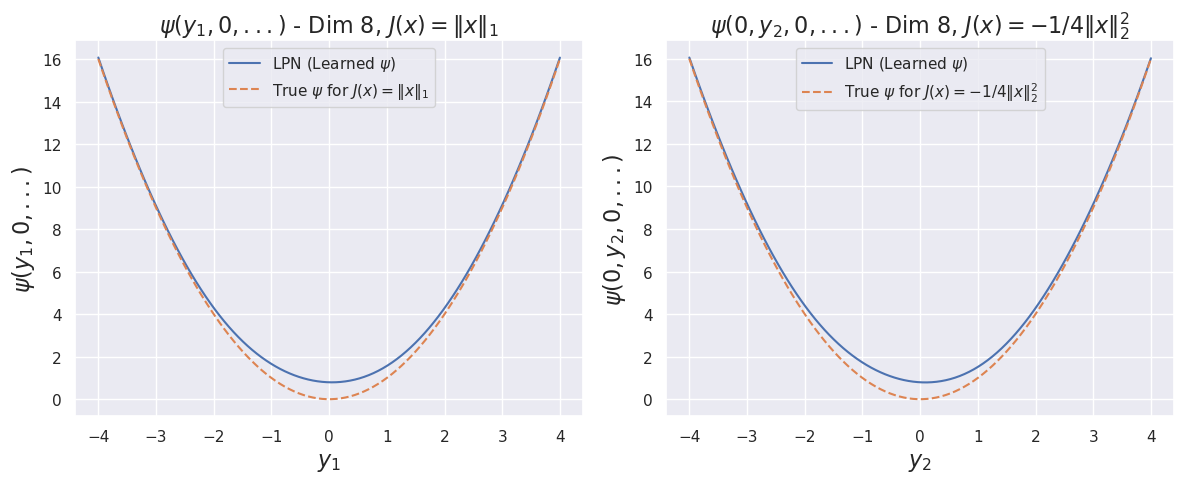

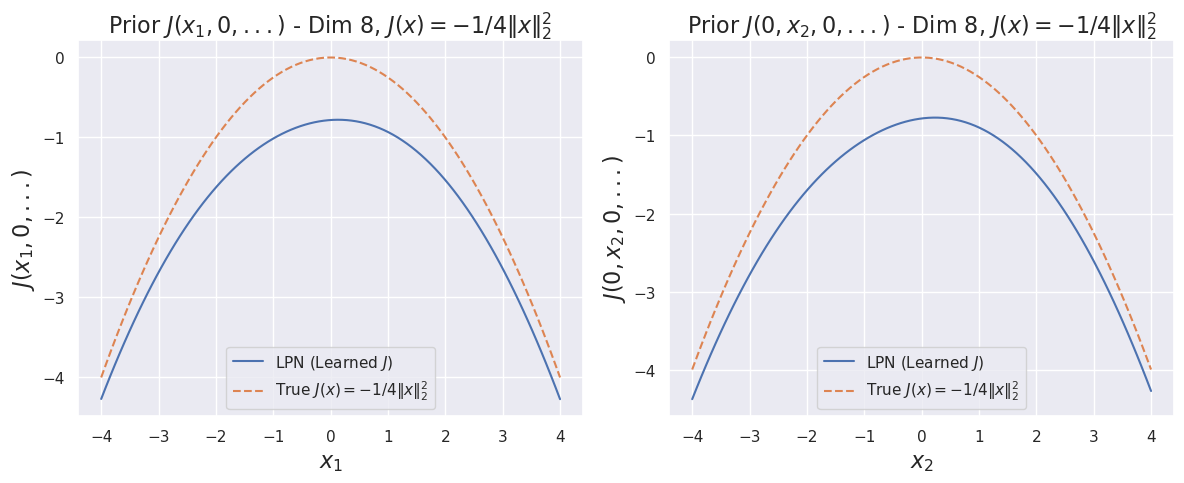

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.3102,  3.5508, -8.0069,  ..., -6.5192, -5.0312, -2.5474],
        [-1.6356,  0.6538, -1.2610,  ...,  5.9876, -7.6196,  2.7311],
        [-1.2896,  0.9204, -5.7408,  ...,  7.4913, -2.9625,  3.0869],
        ...,
        [ 1.2386, -0.3431,  0.4124,  ..., -3.7414, -6.4859, -0.9151],
        [-0.3300, -0.9755, -5.5959,  ...,  7.4721, -5.8357, -5.8277],
        [ 0.8664, -6.2065, -3.7689,  ...,  2.1476,  0.3890,  6.3778]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 2004.4736328125
iteration 0 loss 1151.200927734375


iteration 500 loss 37.92111587524414


iteration 1000 loss 1.9804712533950806


iteration 1500 loss 0.6753832697868347


iteration 2000 loss 0.348416268825531


iteration 2500 loss 0.3039875030517578


iteration 3000 loss 0.20744390785694122


iteration 3500 loss 0.156675323843956


iteration 4000 loss 0.21962451934814453


iteration 4500 loss 0.1327287256717682


iteration 5000 loss 0.10651086270809174


iteration 5500 loss 0.10360310971736908


iteration 6000 loss 0.0834885761141777


iteration 6500 loss 0.08057817816734314


iteration 7000 loss 0.07841640710830688


iteration 7500 loss 0.06646540760993958


iteration 8000 loss 0.06729487329721451


iteration 8500 loss 0.05687885358929634


iteration 9000 loss 0.056688543409109116


iteration 9500 loss 0.05731447413563728


iteration 10000 loss 0.051930975168943405


iteration 10500 loss 0.04743219539523125


iteration 11000 loss 0.044301338493824005


iteration 11500 loss 0.04183327034115791


iteration 12000 loss 0.04017408937215805


iteration 12500 loss 0.03820879012346268


iteration 13000 loss 0.3277389705181122


iteration 13500 loss 0.03801185265183449


iteration 14000 loss 0.03522453084588051


iteration 14500 loss 0.033859364688396454


iteration 15000 loss 0.03234249725937843


iteration 15500 loss 0.031100189313292503


iteration 16000 loss 0.029724719002842903


iteration 16500 loss 0.5421305894851685


iteration 17000 loss 0.029564104974269867


iteration 17500 loss 0.0276707224547863


iteration 18000 loss 0.026322072371840477


iteration 18500 loss 0.025194592773914337


iteration 19000 loss 0.030267877504229546


iteration 19500 loss 0.024979963898658752


iteration 20000 loss 0.023698706179857254


iteration 20500 loss 0.022600805386900902


iteration 21000 loss 0.03854752704501152


iteration 21500 loss 0.022673476487398148


iteration 22000 loss 0.021231966093182564


iteration 22500 loss 0.020225416868925095


iteration 23000 loss 0.030494743958115578


iteration 23500 loss 0.020322492346167564


iteration 24000 loss 0.019121479243040085


iteration 24500 loss 0.018284838646650314


iteration 25000 loss 0.023073026910424232


iteration 25500 loss 0.018470101058483124


iteration 26000 loss 0.017598314210772514


iteration 26500 loss 0.01685260608792305


iteration 27000 loss 0.016206391155719757


iteration 27500 loss 0.017390824854373932


iteration 28000 loss 0.01599845662713051


iteration 28500 loss 0.015430512838065624


iteration 29000 loss 0.01483706571161747


iteration 29500 loss 0.0181022509932518


iteration 30000 loss 0.015032944269478321


iteration 30500 loss 0.01439328771084547


iteration 31000 loss 0.01380800362676382


iteration 31500 loss 0.013334712013602257


iteration 32000 loss 0.036732956767082214


iteration 32500 loss 0.013492298312485218


iteration 33000 loss 0.012815259397029877


iteration 33500 loss 0.012327160686254501


iteration 34000 loss 0.02090577408671379


iteration 34500 loss 0.012319641187787056


iteration 35000 loss 0.011747825890779495


iteration 35500 loss 3.3546903133392334


iteration 36000 loss 0.011858242563903332


iteration 36500 loss 0.011299202218651772


iteration 37000 loss 0.010846409015357494


iteration 37500 loss 0.01124733779579401


iteration 38000 loss 0.010704577900469303


iteration 38500 loss 0.010571470484137535


iteration 39000 loss 0.00997445173561573


iteration 39500 loss 0.009925310499966145


iteration 40000 loss 0.00987041275948286


iteration 40500 loss 0.009468507021665573


iteration 41000 loss 0.010210888460278511


iteration 41500 loss 0.009377757087349892


iteration 42000 loss 0.00897988211363554


iteration 42500 loss 0.009416204877197742


iteration 43000 loss 0.008898626081645489


iteration 43500 loss 0.018904102966189384


iteration 44000 loss 0.008588843047618866


iteration 44500 loss 0.008930196054279804


iteration 45000 loss 0.008218512870371342


iteration 45500 loss 0.008270325139164925


iteration 46000 loss 0.010047183372080326


iteration 46500 loss 0.007951234467327595


iteration 47000 loss 0.00798535905778408


iteration 47500 loss 0.13172779977321625


iteration 48000 loss 0.010087723843753338


iteration 48500 loss 0.007399349939078093


iteration 49000 loss 0.007717493921518326


iteration 49500 loss 0.007265471387654543


iteration 50000 loss 0.030347606167197227


iteration 50500 loss 0.007125360891222954


iteration 51000 loss 0.0071092876605689526


iteration 51500 loss 0.007274652365595102


iteration 52000 loss 0.0069116526283323765


iteration 52500 loss 0.00665485393255949


iteration 53000 loss 0.006643671542406082


iteration 53500 loss 0.006611218210309744


iteration 54000 loss 0.006476438604295254


iteration 54500 loss 0.006455305963754654


iteration 55000 loss 0.011504769325256348


iteration 55500 loss 0.006347594317048788


iteration 56000 loss 0.009369740262627602


iteration 56500 loss 0.006268814206123352


iteration 57000 loss 0.006133129820227623


iteration 57500 loss 0.006725243758410215


iteration 58000 loss 0.006023169495165348


iteration 58500 loss 0.005805274471640587


iteration 59000 loss 0.005869071930646896


iteration 59500 loss 0.005719886161386967


iteration 60000 loss 0.005686687305569649


iteration 60500 loss 0.005830137059092522


iteration 61000 loss 0.005579742603003979


iteration 61500 loss 0.00561291491612792


iteration 62000 loss 0.0055344803258776665


iteration 62500 loss 0.005524376407265663


iteration 63000 loss 0.09386100620031357


iteration 63500 loss 0.010149874724447727


iteration 64000 loss 0.009830646216869354


iteration 64500 loss 0.03683992102742195


iteration 65000 loss 0.0062254806980490685


iteration 65500 loss 0.0052808597683906555


iteration 66000 loss 0.006815569009631872


iteration 66500 loss 0.007765776477754116


iteration 67000 loss 0.005179135128855705


iteration 67500 loss 0.005026219412684441


iteration 68000 loss 0.006264484021812677


iteration 68500 loss 0.006596911698579788


iteration 69000 loss 0.005104343872517347


iteration 69500 loss 0.004858354572206736


iteration 70000 loss 0.014453529380261898


iteration 70500 loss 0.07451621443033218


iteration 71000 loss 0.9385325908660889


iteration 71500 loss 0.004730712156742811


iteration 72000 loss 0.004688093904405832


iteration 72500 loss 0.0047272550873458385


iteration 73000 loss 0.004820425994694233


iteration 73500 loss 0.005125410854816437


iteration 74000 loss 0.004644144792109728


iteration 74500 loss 0.0045040980912745


iteration 75000 loss 0.004633055534213781


iteration 75500 loss 0.004457022529095411


iteration 76000 loss 0.004528358578681946


iteration 76500 loss 0.011320961639285088


iteration 77000 loss 0.004365186672657728


iteration 77500 loss 0.004338930826634169


iteration 78000 loss 0.010609853081405163


iteration 78500 loss 0.018129609525203705


iteration 79000 loss 0.01613643206655979


iteration 79500 loss 0.004486887715756893


iteration 80000 loss 0.6541781425476074


iteration 80500 loss 0.004716386552900076


iteration 81000 loss 0.0041740392334759235


iteration 81500 loss 0.005754226818680763


iteration 82000 loss 0.015300404280424118


iteration 82500 loss 0.004233542364090681


iteration 83000 loss 0.0048888614401221275


iteration 83500 loss 0.0043673086911439896


iteration 84000 loss 0.009028423577547073


iteration 84500 loss 0.392128586769104


iteration 85000 loss 0.015569929033517838


iteration 85500 loss 0.004147552419453859


iteration 86000 loss 0.006464335601776838


iteration 86500 loss 0.193272203207016


iteration 87000 loss 0.11062661558389664


iteration 87500 loss 0.0040762596763670444


iteration 88000 loss 0.0065606157295405865


iteration 88500 loss 0.16972430050373077


iteration 89000 loss 0.01023685559630394


iteration 89500 loss 0.017637377604842186


iteration 90000 loss 0.005502141546458006


iteration 90500 loss 0.005679024383425713


iteration 91000 loss 0.11458001285791397


iteration 91500 loss 0.12268625944852829


iteration 92000 loss 0.15735283493995667


iteration 92500 loss 0.0055107674561440945


iteration 93000 loss 0.004017856437712908


iteration 93500 loss 0.005380869377404451


iteration 94000 loss 0.01504503097385168


iteration 94500 loss 0.005041386932134628


iteration 95000 loss 0.024776607751846313


iteration 95500 loss 0.013578166253864765


iteration 96000 loss 0.021116528660058975


iteration 96500 loss 0.006351761985570192


iteration 97000 loss 0.00666111009195447


iteration 97500 loss 0.005171924363821745


iteration 98000 loss 0.005532941315323114


iteration 98500 loss 0.009594492614269257


iteration 99000 loss 0.006121094338595867


iteration 99500 loss 0.003950626589357853


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.011371842585504055


iteration 100500 loss 0.0035509434528648853


iteration 101000 loss 0.003496943274512887


iteration 101500 loss 0.003443956607952714


iteration 102000 loss 0.003389752935618162


iteration 102500 loss 0.0033334570471197367


iteration 103000 loss 0.0032744985073804855


iteration 103500 loss 0.0032125457655638456


iteration 104000 loss 0.003147334326058626


iteration 104500 loss 0.003078659065067768


iteration 105000 loss 0.0030171077232807875


iteration 105500 loss 0.002964683575555682


iteration 106000 loss 0.0029672475066035986


iteration 106500 loss 0.002881048945710063


iteration 107000 loss 0.0028429203666746616


iteration 107500 loss 0.0028108530677855015


iteration 108000 loss 0.0027797133661806583


iteration 108500 loss 0.0037973541766405106


iteration 109000 loss 0.0027215348090976477


iteration 109500 loss 0.0026976161170750856


iteration 110000 loss 0.0026738387532532215


iteration 110500 loss 0.003085274249315262


iteration 111000 loss 0.0026241547893732786


iteration 111500 loss 0.0026024796534329653


iteration 112000 loss 0.0025825633201748133


iteration 112500 loss 0.0025624835398048162


iteration 113000 loss 0.002544680144637823


iteration 113500 loss 0.00252575078047812


iteration 114000 loss 0.002507177647203207


iteration 114500 loss 0.002765234559774399


iteration 115000 loss 0.002473119180649519


iteration 115500 loss 0.0024578850716352463


iteration 116000 loss 0.00243963859975338


iteration 116500 loss 0.0024440791457891464


iteration 117000 loss 0.0024108155630528927


iteration 117500 loss 0.00239582103677094


iteration 118000 loss 0.002382423961535096


iteration 118500 loss 0.0023681819438934326


iteration 119000 loss 0.002355338307097554


iteration 119500 loss 0.0023416399490088224


iteration 120000 loss 0.006510274484753609


iteration 120500 loss 0.0023159098345786333


iteration 121000 loss 0.0023032501339912415


iteration 121500 loss 0.003331974381580949


iteration 122000 loss 0.0022811752278357744


iteration 122500 loss 0.0022692119237035513


iteration 123000 loss 0.0022581741213798523


iteration 123500 loss 0.002246569376438856


iteration 124000 loss 0.0022352165542542934


iteration 124500 loss 0.002224659314379096


iteration 125000 loss 0.0022135870531201363


iteration 125500 loss 0.002217906294390559


iteration 126000 loss 0.0021959319710731506


iteration 126500 loss 0.0021826247684657574


iteration 127000 loss 0.002172381617128849


iteration 127500 loss 0.002162505639716983


iteration 128000 loss 0.002152658300474286


iteration 128500 loss 0.002142481505870819


iteration 129000 loss 0.0021335489582270384


iteration 129500 loss 0.0021241491194814444


iteration 130000 loss 0.002114879433065653


iteration 130500 loss 0.0021057999692857265


iteration 131000 loss 0.0020966453012079


iteration 131500 loss 0.002087824745103717


iteration 132000 loss 0.0020790360867977142


iteration 132500 loss 0.0020703147165477276


iteration 133000 loss 0.0020619037095457315


iteration 133500 loss 0.0020533644128590822


iteration 134000 loss 0.002044988563284278


iteration 134500 loss 0.0020371205173432827


iteration 135000 loss 0.0023914205376058817


iteration 135500 loss 0.0020213276147842407


iteration 136000 loss 0.005634140223264694


iteration 136500 loss 0.002005555434152484


iteration 137000 loss 0.0019978226628154516


iteration 137500 loss 0.001990310149267316


iteration 138000 loss 0.0019825114868581295


iteration 138500 loss 0.002134757349267602


iteration 139000 loss 0.001967418473213911


iteration 139500 loss 0.0019601425155997276


iteration 140000 loss 0.0019532139413058758


iteration 140500 loss 0.0019464625511318445


iteration 141000 loss 0.0019402247853577137


iteration 141500 loss 0.0019680135883390903


iteration 142000 loss 0.0019257350359112024


iteration 142500 loss 0.0019187158904969692


iteration 143000 loss 0.00472457567229867


iteration 143500 loss 0.001905938028357923


iteration 144000 loss 0.0018988741794601083


iteration 144500 loss 0.0018930474761873484


iteration 145000 loss 0.0020401410292834044


iteration 145500 loss 0.0018800025573000312


iteration 146000 loss 0.0026821931824088097


iteration 146500 loss 0.0018679255153983831


iteration 147000 loss 0.0018614288419485092


iteration 147500 loss 0.0018553667468950152


iteration 148000 loss 0.0018495316617190838


iteration 148500 loss 0.0018440826097503304


iteration 149000 loss 0.0018378766253590584


iteration 149500 loss 0.0018325457349419594


iteration 150000 loss 0.0018269215943291783


iteration 150500 loss 0.0018206214299425483


iteration 151000 loss 0.0026693420950323343


iteration 151500 loss 0.009675959125161171


iteration 152000 loss 0.002828980563208461


iteration 152500 loss 0.0017986227758228779


iteration 153000 loss 0.0017929214518517256


iteration 153500 loss 0.0017875549383461475


iteration 154000 loss 0.0017870516749098897


iteration 154500 loss 0.0017767566023394465


iteration 155000 loss 0.0017717782175168395


iteration 155500 loss 0.0017684270860627294


iteration 156000 loss 0.0017617156263440847


iteration 156500 loss 0.001756411511451006


iteration 157000 loss 0.0017510935431346297


iteration 157500 loss 0.0017458811635151505


iteration 158000 loss 0.001740884967148304


iteration 158500 loss 0.001736127189360559


iteration 159000 loss 0.0017314336728304625


iteration 159500 loss 0.0017261202447116375


iteration 160000 loss 0.0026833717711269855


iteration 160500 loss 0.0017269146628677845


iteration 161000 loss 0.001711311750113964


iteration 161500 loss 0.0017064902931451797


iteration 162000 loss 0.0017174079548567533


iteration 162500 loss 0.0016976239858195186


iteration 163000 loss 0.001692325109615922


iteration 163500 loss 0.001687890267930925


iteration 164000 loss 0.0016828730003908277


iteration 164500 loss 0.0016787003260105848


iteration 165000 loss 0.0016747309127822518


iteration 165500 loss 0.0016694121295586228


iteration 166000 loss 0.0016652982449159026


iteration 166500 loss 0.0016610051970928907


iteration 167000 loss 0.0016566235572099686


iteration 167500 loss 0.0016525192186236382


iteration 168000 loss 0.0016478137113153934


iteration 168500 loss 0.0016435073921456933


iteration 169000 loss 0.0016394669655710459


iteration 169500 loss 0.001640751608647406


iteration 170000 loss 0.0016312386142089963


iteration 170500 loss 0.0016273458022624254


iteration 171000 loss 0.0025037399027496576


iteration 171500 loss 0.0016189230373129249


iteration 172000 loss 0.0016146698035299778


iteration 172500 loss 0.001610710402019322


iteration 173000 loss 0.0020018338691443205


iteration 173500 loss 0.001602280419319868


iteration 174000 loss 0.00159845978487283


iteration 174500 loss 0.0015954814152792096


iteration 175000 loss 0.0015904632164165378


iteration 175500 loss 0.0015868589980527759


iteration 176000 loss 0.0015833298675715923


iteration 176500 loss 0.001605766243301332


iteration 177000 loss 0.0018616445595398545


iteration 177500 loss 0.0015720038209110498


iteration 178000 loss 0.007219722960144281


iteration 178500 loss 0.0015644851373508573


iteration 179000 loss 0.0015612756833434105


iteration 179500 loss 0.0015596888260915875


iteration 180000 loss 0.0015541522298008204


iteration 180500 loss 0.005607708357274532


iteration 181000 loss 0.0015464180614799261


iteration 181500 loss 0.0015429018530994654


iteration 182000 loss 0.001539669930934906


iteration 182500 loss 0.001535729505121708


iteration 183000 loss 0.0015322250546887517


iteration 183500 loss 0.001529008848592639


iteration 184000 loss 0.0015254117315635085


iteration 184500 loss 0.0018888164777308702


iteration 185000 loss 0.00151846616063267


iteration 185500 loss 0.0016908684046939015


iteration 186000 loss 0.001511802664026618


iteration 186500 loss 0.00150880787987262


iteration 187000 loss 0.0015050922520458698


iteration 187500 loss 0.0015022085281088948


iteration 188000 loss 0.0014990516938269138


iteration 188500 loss 0.0014956177910789847


iteration 189000 loss 0.0014925687573850155


iteration 189500 loss 0.001489456044510007


iteration 190000 loss 0.0014858193462714553


iteration 190500 loss 0.0014828980201855302


iteration 191000 loss 0.0014796038158237934


iteration 191500 loss 0.001526853535324335


iteration 192000 loss 0.0014731991104781628


iteration 192500 loss 0.0014700840692967176


iteration 193000 loss 0.0014677798608317971


iteration 193500 loss 0.001464111846871674


iteration 194000 loss 0.007115032058209181


iteration 194500 loss 0.0015023795422166586


iteration 195000 loss 0.0014546315651386976


iteration 195500 loss 0.0014522544806823134


iteration 196000 loss 0.0014489633031189442


iteration 196500 loss 0.0014462597901001573


iteration 197000 loss 0.0014436243800446391


iteration 197500 loss 0.02446920983493328


iteration 198000 loss 0.0014377847546711564


iteration 198500 loss 0.00143474992364645


iteration 199000 loss 0.0014319951878860593


iteration 199500 loss 0.0014291234547272325


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0014262148179113865


iteration 200500 loss 0.0014258550945669413


iteration 201000 loss 0.0014253989793360233


iteration 201500 loss 0.0014248270308598876


iteration 202000 loss 0.0014241047902032733


iteration 202500 loss 0.0014231938403099775


iteration 203000 loss 0.0014220339944586158


iteration 203500 loss 0.0014205483021214604


iteration 204000 loss 0.0014186553889885545


iteration 204500 loss 0.0014162396546453238


iteration 205000 loss 0.0014133660588413477


iteration 205500 loss 0.001410690718330443


iteration 206000 loss 0.0014078987296670675


iteration 206500 loss 0.0014051040634512901


iteration 207000 loss 0.0014023067196831107


iteration 207500 loss 0.001517026568762958


iteration 208000 loss 0.0013970977161079645


iteration 208500 loss 0.0013944399543106556


iteration 209000 loss 0.0013917844044044614


iteration 209500 loss 0.0013891730923205614


iteration 210000 loss 0.0013865266228094697


iteration 210500 loss 0.0013839933089911938


iteration 211000 loss 0.0013813382247462869


iteration 211500 loss 0.0013785673072561622


iteration 212000 loss 0.0013763855677098036


iteration 212500 loss 0.0013740368885919452


iteration 213000 loss 0.0013714481610804796


iteration 213500 loss 0.0013688437175005674


iteration 214000 loss 0.001366386073641479


iteration 214500 loss 0.001363899209536612


iteration 215000 loss 0.0013615608913823962


iteration 215500 loss 0.0013590777525678277


iteration 216000 loss 0.0013565648114308715


iteration 216500 loss 0.0013543422101065516


iteration 217000 loss 0.0013520678039640188


iteration 217500 loss 0.0013496503233909607


iteration 218000 loss 0.0013473605504259467


iteration 218500 loss 0.0013449559919536114


iteration 219000 loss 0.0013424440985545516


iteration 219500 loss 0.0013402344193309546


iteration 220000 loss 0.001337812514975667


iteration 220500 loss 0.0013356844428926706


iteration 221000 loss 0.0013332368107512593


iteration 221500 loss 0.001337685389444232


iteration 222000 loss 0.0013283846201375127


iteration 222500 loss 0.0013263712171465158


iteration 223000 loss 0.0013240558328107


iteration 223500 loss 0.0013218778185546398


iteration 224000 loss 0.0013195077190175653


iteration 224500 loss 0.0013171517057344317


iteration 225000 loss 0.0013151619350537658


iteration 225500 loss 0.0013857355806976557


iteration 226000 loss 0.0013108976418152452


iteration 226500 loss 0.001404898357577622


iteration 227000 loss 0.0013063509250059724


iteration 227500 loss 0.0014438634971156716


iteration 228000 loss 0.0013019097968935966


iteration 228500 loss 0.0012997803278267384


iteration 229000 loss 0.001297987881116569


iteration 229500 loss 0.0012955873971804976


iteration 230000 loss 0.0012933736434206367


iteration 230500 loss 0.0012913249665871263


iteration 231000 loss 0.0012890740763396025


iteration 231500 loss 0.0012869379715994


iteration 232000 loss 0.0012847884790971875


iteration 232500 loss 0.0012828445760533214


iteration 233000 loss 0.0012806826271116734


iteration 233500 loss 0.0012789195170626044


iteration 234000 loss 0.0012768112355843186


iteration 234500 loss 0.001274782931432128


iteration 235000 loss 0.0012727499706670642


iteration 235500 loss 0.0012706374982371926


iteration 236000 loss 0.0012685765977948904


iteration 236500 loss 0.001266503008082509


iteration 237000 loss 0.001264583203010261


iteration 237500 loss 0.0012624177616089582


iteration 238000 loss 0.0012607367243617773


iteration 238500 loss 0.0012845402816310525


iteration 239000 loss 0.0012567739468067884


iteration 239500 loss 0.0012548805680125952


iteration 240000 loss 0.0012528528459370136


iteration 240500 loss 0.001251030946150422


iteration 241000 loss 0.001248953863978386


iteration 241500 loss 0.0012476672418415546


iteration 242000 loss 0.0012450732756406069


iteration 242500 loss 0.0012509282678365707


iteration 243000 loss 0.001241327146999538


iteration 243500 loss 0.0012393607757985592


iteration 244000 loss 0.0012490374501794577


iteration 244500 loss 0.0012356516672298312


iteration 245000 loss 0.0012336699292063713


iteration 245500 loss 0.0012318311491981149


iteration 246000 loss 0.0012300749076530337


iteration 246500 loss 0.0012282207608222961


iteration 247000 loss 0.0012267334386706352


iteration 247500 loss 0.0012245316756889224


iteration 248000 loss 0.0012226890539750457


iteration 248500 loss 0.0012211548164486885


iteration 249000 loss 0.0012195365270599723


iteration 249500 loss 0.0012516515562310815


iteration 250000 loss 0.001215564669109881


iteration 250500 loss 0.0012137313606217504


iteration 251000 loss 0.0012118751183152199


iteration 251500 loss 0.0012102071195840836


iteration 252000 loss 0.0012084691552445292


iteration 252500 loss 0.0012064804323017597


iteration 253000 loss 0.0012049636570736766


iteration 253500 loss 0.0012031608493998647


iteration 254000 loss 0.0012014935491606593


iteration 254500 loss 0.001199687598273158


iteration 255000 loss 0.001198114245198667


iteration 255500 loss 0.0011963311117142439


iteration 256000 loss 0.0011945614824071527


iteration 256500 loss 0.0012033957755193114


iteration 257000 loss 0.0011913307243958116


iteration 257500 loss 0.0011896425858139992


iteration 258000 loss 0.001187862129881978


iteration 258500 loss 0.0011861958773806691


iteration 259000 loss 0.0011845234548673034


iteration 259500 loss 0.0017481420654803514


iteration 260000 loss 0.0011813727905973792


iteration 260500 loss 0.0011798326158896089


iteration 261000 loss 0.0011781381908804178


iteration 261500 loss 0.0011763996444642544


iteration 262000 loss 0.001174942939542234


iteration 262500 loss 0.0011731720296666026


iteration 263000 loss 0.0011718027526512742


iteration 263500 loss 0.0011701429029926658


iteration 264000 loss 0.0011686396319419146


iteration 264500 loss 0.0011687838705256581


iteration 265000 loss 0.0011653269175440073


iteration 265500 loss 0.0011637364514172077


iteration 266000 loss 0.001162066007964313


iteration 266500 loss 0.0011605634354054928


iteration 267000 loss 0.0011588841443881392


iteration 267500 loss 0.00115739565808326


iteration 268000 loss 0.001155737554654479


iteration 268500 loss 0.0011542279971763492


iteration 269000 loss 0.001152651384472847


iteration 269500 loss 0.0011513442732393742


iteration 270000 loss 0.0011495582293719053


iteration 270500 loss 0.0011479700915515423


iteration 271000 loss 0.0011463690316304564


iteration 271500 loss 0.0011449649464339018


iteration 272000 loss 0.0011433864710852504


iteration 272500 loss 0.001142369699664414


iteration 273000 loss 0.001140353619121015


iteration 273500 loss 0.0011695370776578784


iteration 274000 loss 0.0011376177426427603


iteration 274500 loss 0.0011358119081705809


iteration 275000 loss 0.001134333899244666


iteration 275500 loss 0.0011670493986457586


iteration 276000 loss 0.001131186611019075


iteration 276500 loss 0.0011298236204311252


iteration 277000 loss 0.0011282905470579863


iteration 277500 loss 0.001157892751507461


iteration 278000 loss 0.001125345123000443


iteration 278500 loss 0.0011238286970183253


iteration 279000 loss 0.0011223678011447191


iteration 279500 loss 0.0011210304219275713


iteration 280000 loss 0.0011195170227438211


iteration 280500 loss 0.0011180556612089276


iteration 281000 loss 0.0011165682226419449


iteration 281500 loss 0.001115155522711575


iteration 282000 loss 0.0011137903202325106


iteration 282500 loss 0.001112322206608951


iteration 283000 loss 0.0011110161431133747


iteration 283500 loss 0.001109508564695716


iteration 284000 loss 0.0011083143763244152


iteration 284500 loss 0.0011069189058616757


iteration 285000 loss 0.001106875715777278


iteration 285500 loss 0.0011042404221370816


iteration 286000 loss 0.0011028294684365392


iteration 286500 loss 0.0011014890624210238


iteration 287000 loss 0.0011000960366800427


iteration 287500 loss 0.0010987010318785906


iteration 288000 loss 0.001097415923140943


iteration 288500 loss 0.0010960270883515477


iteration 289000 loss 0.0010947685223072767


iteration 289500 loss 0.001298263086937368


iteration 290000 loss 0.0010921313660219312


iteration 290500 loss 0.001102346577681601


iteration 291000 loss 0.0010895563755184412


iteration 291500 loss 0.0010881477501243353


iteration 292000 loss 0.0010869692778214812


iteration 292500 loss 0.00108556286431849


iteration 293000 loss 0.001084430725313723


iteration 293500 loss 0.0010834445711225271


iteration 294000 loss 0.0010818783193826675


iteration 294500 loss 0.001082071801647544


iteration 295000 loss 0.0010793578112497926


iteration 295500 loss 0.0011243225308135152


iteration 296000 loss 0.0010768540669232607


iteration 296500 loss 0.0011765914969146252


iteration 297000 loss 0.0010743184247985482


iteration 297500 loss 0.0010729567147791386


iteration 298000 loss 0.0010717466939240694


iteration 298500 loss 0.0010704335290938616


iteration 299000 loss 0.001069231191650033


iteration 299500 loss 0.0010679432889446616


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0010668454924598336


iteration 300500 loss 0.001066717435605824


iteration 301000 loss 0.0010665496811270714


iteration 301500 loss 0.0010663327993825078


iteration 302000 loss 0.0010660478146746755


iteration 302500 loss 0.0010656885569915175


iteration 303000 loss 0.0010652246419340372


iteration 303500 loss 0.0010646324371919036


iteration 304000 loss 0.0010638709645718336


iteration 304500 loss 0.001062898663803935


iteration 305000 loss 0.0010616612853482366


iteration 305500 loss 0.0010603191331028938


iteration 306000 loss 0.0010592842008918524


iteration 306500 loss 0.0010579697554931045


iteration 307000 loss 0.0010567986173555255


iteration 307500 loss 0.0010556773049756885


iteration 308000 loss 0.001054393476806581


iteration 308500 loss 0.0010532389860600233


iteration 309000 loss 0.001051940955221653


iteration 309500 loss 0.0010508069535717368


iteration 310000 loss 0.0010496589820832014


iteration 310500 loss 0.0010483411606401205


iteration 311000 loss 0.0010473005240783095


iteration 311500 loss 0.0010459939949214458


iteration 312000 loss 0.001044910284690559


iteration 312500 loss 0.001043706783093512


iteration 313000 loss 0.0010424948995932937


iteration 313500 loss 0.001041238778270781


iteration 314000 loss 0.0010401115287095308


iteration 314500 loss 0.0010389393428340554


iteration 315000 loss 0.0010376883437857032


iteration 315500 loss 0.00103675271384418


iteration 316000 loss 0.001035561552271247


iteration 316500 loss 0.0010343748144805431


iteration 317000 loss 0.001033363863825798


iteration 317500 loss 0.0010320845758542418


iteration 318000 loss 0.00103109166957438


iteration 318500 loss 0.001029987703077495


iteration 319000 loss 0.0010287045734003186


iteration 319500 loss 0.0010277815163135529


iteration 320000 loss 0.0010266092140227556


iteration 320500 loss 0.00102548161521554


iteration 321000 loss 0.0010245343437418342


iteration 321500 loss 0.0010233253706246614


iteration 322000 loss 0.0010222848504781723


iteration 322500 loss 0.0010212227934971452


iteration 323000 loss 0.0010199620155617595


iteration 323500 loss 0.001019099960103631


iteration 324000 loss 0.0010180043755099177


iteration 324500 loss 0.0010168651351705194


iteration 325000 loss 0.0010158050572499633


iteration 325500 loss 0.0010146405547857285


iteration 326000 loss 0.0010136882774531841


iteration 326500 loss 0.0010124772088602185


iteration 327000 loss 0.0010115044424310327


iteration 327500 loss 0.0010103697422891855


iteration 328000 loss 0.0010093343444168568


iteration 328500 loss 0.0010082748485729098


iteration 329000 loss 0.001007168204523623


iteration 329500 loss 0.0010061459615826607


iteration 330000 loss 0.0010050012497231364


iteration 330500 loss 0.0010040182387456298


iteration 331000 loss 0.0010028708493337035


iteration 331500 loss 0.001001916010864079


iteration 332000 loss 0.0010007098317146301


iteration 332500 loss 0.0009998891036957502


iteration 333000 loss 0.0009989402024075389


iteration 333500 loss 0.0009977489244192839


iteration 334000 loss 0.0009969121310859919


iteration 334500 loss 0.0009958856971934438


iteration 335000 loss 0.0009948273655027151


iteration 335500 loss 0.0009937674039974809


iteration 336000 loss 0.0009927424835041165


iteration 336500 loss 0.0009918994037434459


iteration 337000 loss 0.0009908180218189955


iteration 337500 loss 0.0009898304706439376


iteration 338000 loss 0.000988872372545302


iteration 338500 loss 0.0009877650300040841


iteration 339000 loss 0.0009869229979813099


iteration 339500 loss 0.0009858597768470645


iteration 340000 loss 0.000984909012913704


iteration 340500 loss 0.0009841021383181214


iteration 341000 loss 0.0009830727940425277


iteration 341500 loss 0.0009821191197261214


iteration 342000 loss 0.0009811549680307508


iteration 342500 loss 0.0009800256229937077


iteration 343000 loss 0.0009792487835511565


iteration 343500 loss 0.0009782752022147179


iteration 344000 loss 0.0009771871846169233


iteration 344500 loss 0.0009764101705513895


iteration 345000 loss 0.0009754252969287336


iteration 345500 loss 0.0009744485141709447


iteration 346000 loss 0.000973499205429107


iteration 346500 loss 0.0009724777773953974


iteration 347000 loss 0.0009716819622553885


iteration 347500 loss 0.0009706779383122921


iteration 348000 loss 0.000969746324699372


iteration 348500 loss 0.0009687556303106248


iteration 349000 loss 0.0009678410715423524


iteration 349500 loss 0.0009669567225500941


iteration 350000 loss 0.0009658948401920497


iteration 350500 loss 0.0009651063592173159


iteration 351000 loss 0.0009641386568546295


iteration 351500 loss 0.0009632316650822759


iteration 352000 loss 0.0009623598889447749


iteration 352500 loss 0.0009614141308702528


iteration 353000 loss 0.0009605858358554542


iteration 353500 loss 0.0009596836171112955


iteration 354000 loss 0.0009587003150954843


iteration 354500 loss 0.0009578695171512663


iteration 355000 loss 0.0009568172390572727


iteration 355500 loss 0.000956099305767566


iteration 356000 loss 0.0009552836418151855


iteration 356500 loss 0.0009542489424347878


iteration 357000 loss 0.0009534791461192071


iteration 357500 loss 0.0009525566129013896


iteration 358000 loss 0.0009516301215626299


iteration 358500 loss 0.0009509105584584177


iteration 359000 loss 0.0009500061860308051


iteration 359500 loss 0.0009490903466939926


iteration 360000 loss 0.0009482718305662274


iteration 360500 loss 0.0009472894016653299


iteration 361000 loss 0.0009465295006521046


iteration 361500 loss 0.0009455828694626689


iteration 362000 loss 0.0009447569609619677


iteration 362500 loss 0.0009439658024348319


iteration 363000 loss 0.0009429965866729617


iteration 363500 loss 0.0009421550785191357


iteration 364000 loss 0.0009411602513864636


iteration 364500 loss 0.000940475205425173


iteration 365000 loss 0.0009396228706464171


iteration 365500 loss 0.0009386300225742161


iteration 366000 loss 0.0009380051051266491


iteration 366500 loss 0.0009372119093313813


iteration 367000 loss 0.0009382283897139132


iteration 367500 loss 0.0009355426882393658


iteration 368000 loss 0.0009346760925836861


iteration 368500 loss 0.0009338203817605972


iteration 369000 loss 0.0009330385364592075


iteration 369500 loss 0.0009320536628365517


iteration 370000 loss 0.000931391550693661


iteration 370500 loss 0.0009305963758379221


iteration 371000 loss 0.0009296757052652538


iteration 371500 loss 0.0009289357694797218


iteration 372000 loss 0.0009280048543587327


iteration 372500 loss 0.0009272753377445042


iteration 373000 loss 0.0009265108965337276


iteration 373500 loss 0.0009255519835278392


iteration 374000 loss 0.0009249132126569748


iteration 374500 loss 0.0009242030209861696


iteration 375000 loss 0.0009233385790139437


iteration 375500 loss 0.0009225683170370758


iteration 376000 loss 0.0009218365885317326


iteration 376500 loss 0.0009219953208230436


iteration 377000 loss 0.0009202429791912436


iteration 377500 loss 0.0009194864542223513


iteration 378000 loss 0.0009185945382341743


iteration 378500 loss 0.0009178809123113751


iteration 379000 loss 0.0009169779950752854


iteration 379500 loss 0.0009162925416603684


iteration 380000 loss 0.0009154934668913484


iteration 380500 loss 0.0009146705851890147


iteration 381000 loss 0.0009138903114944696


iteration 381500 loss 0.0009130311664193869


iteration 382000 loss 0.0009123766794800758


iteration 382500 loss 0.000911545183043927


iteration 383000 loss 0.0009107741061598063


iteration 383500 loss 0.0009099774761125445


iteration 384000 loss 0.0009091964457184076


iteration 384500 loss 0.0009084651828743517


iteration 385000 loss 0.0009076066198758781


iteration 385500 loss 0.0009068947983905673


iteration 386000 loss 0.0009060002630576491


iteration 386500 loss 0.000905360619071871


iteration 387000 loss 0.0009046452469192445


iteration 387500 loss 0.0009059142903424799


iteration 388000 loss 0.0009031514637172222


iteration 388500 loss 0.0009023878956213593


iteration 389000 loss 0.0009015583200380206


iteration 389500 loss 0.0009009057539515197


iteration 390000 loss 0.0009000860736705363


iteration 390500 loss 0.0008993877563625574


iteration 391000 loss 0.0008987019537016749


iteration 391500 loss 0.0008978843688964844


iteration 392000 loss 0.000897183024790138


iteration 392500 loss 0.0008963188738562167


iteration 393000 loss 0.0008957109530456364


iteration 393500 loss 0.0008950379560701549


iteration 394000 loss 0.0008942030253820121


iteration 394500 loss 0.000893537187948823


iteration 395000 loss 0.0008927437011152506


iteration 395500 loss 0.0008920443360693753


iteration 396000 loss 0.0008913436904549599


iteration 396500 loss 0.0008916034712456167


iteration 397000 loss 0.0008899319800548255


iteration 397500 loss 0.0008892542100511491


iteration 398000 loss 0.0008884573471732438


iteration 398500 loss 0.0008877240470610559


iteration 399000 loss 0.0008869400480762124


iteration 399500 loss 0.0008863859693519771


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0008856877684593201


iteration 400500 loss 0.0008856093045324087


iteration 401000 loss 0.000885499466676265


iteration 401500 loss 0.0008853590697981417


iteration 402000 loss 0.0008851766469888389


iteration 402500 loss 0.0008849399746395648


iteration 403000 loss 0.0008846542332321405


iteration 403500 loss 0.0008842939860187471


iteration 404000 loss 0.0008838482899591327


iteration 404500 loss 0.0008833098690956831


iteration 405000 loss 0.0008826653356663883


iteration 405500 loss 0.0008819520007818937


iteration 406000 loss 0.0008812308660708368


iteration 406500 loss 0.0008805171819403768


iteration 407000 loss 0.0008798029739409685


iteration 407500 loss 0.0008790941210463643


iteration 408000 loss 0.000878384686075151


iteration 408500 loss 0.0008776818867772818


iteration 409000 loss 0.0008769696578383446


iteration 409500 loss 0.0008762595243752003


iteration 410000 loss 0.0008755563176237047


iteration 410500 loss 0.0008748502004891634


iteration 411000 loss 0.0008741538040339947


iteration 411500 loss 0.0008734571165405214


iteration 412000 loss 0.0008727558306418359


iteration 412500 loss 0.0008720571058802307


iteration 413000 loss 0.000871360651217401


iteration 413500 loss 0.0008706721127964556


iteration 414000 loss 0.0008699794998392463


iteration 414500 loss 0.0008692909614183009


iteration 415000 loss 0.0008685971261002123


iteration 415500 loss 0.0008679145248606801


iteration 416000 loss 0.000867230468429625


iteration 416500 loss 0.0008665494387969375


iteration 417000 loss 0.0008658657898195088


iteration 417500 loss 0.0008651876705698669


iteration 418000 loss 0.0008645069319754839


iteration 418500 loss 0.0008638324216008186


iteration 419000 loss 0.0008631570381112397


iteration 419500 loss 0.0008624835172668099


iteration 420000 loss 0.0008618142455816269


iteration 420500 loss 0.0008611466037109494


iteration 421000 loss 0.0008604776230640709


iteration 421500 loss 0.0008598113199695945


iteration 422000 loss 0.0008591464720666409


iteration 422500 loss 0.0008584822644479573


iteration 423000 loss 0.000857820559758693


iteration 423500 loss 0.0008571627549827099


iteration 424000 loss 0.0008565036696381867


iteration 424500 loss 0.0008558476692996919


iteration 425000 loss 0.0008551894570700824


iteration 425500 loss 0.0008545388700440526


iteration 426000 loss 0.0008538842666894197


iteration 426500 loss 0.0008532328647561371


iteration 427000 loss 0.0008525852463208139


iteration 427500 loss 0.000851937395054847


iteration 428000 loss 0.0008512893109582365


iteration 428500 loss 0.0008506443118676543


iteration 429000 loss 0.0008500004187226295


iteration 429500 loss 0.0008493571076542139


iteration 430000 loss 0.0008487150771543384


iteration 430500 loss 0.0008480746182613075


iteration 431000 loss 0.0008474366622976959


iteration 431500 loss 0.0008468037121929228


iteration 432000 loss 0.0008461633697152138


iteration 432500 loss 0.000845530943479389


iteration 433000 loss 0.0008448994485661387


iteration 433500 loss 0.0008442681282758713


iteration 434000 loss 0.0008436380885541439


iteration 434500 loss 0.0008430092129856348


iteration 435000 loss 0.0008423845865763724


iteration 435500 loss 0.0008417583303526044


iteration 436000 loss 0.000841134344227612


iteration 436500 loss 0.0008405068656429648


iteration 437000 loss 0.0008398860809393227


iteration 437500 loss 0.0008392641902901232


iteration 438000 loss 0.0008386453264392912


iteration 438500 loss 0.0008380274521186948


iteration 439000 loss 0.0008374107419513166


iteration 439500 loss 0.0008367939153686166


iteration 440000 loss 0.0008361812797375023


iteration 440500 loss 0.0008355673053301871


iteration 441000 loss 0.0008349573472514749


iteration 441500 loss 0.0008343434892594814


iteration 442000 loss 0.0008337333565577865


iteration 442500 loss 0.000833125552162528


iteration 443000 loss 0.0008325196686200798


iteration 443500 loss 0.0008319127955473959


iteration 444000 loss 0.0008313106372952461


iteration 444500 loss 0.0008307062671519816


iteration 445000 loss 0.0008301043417304754


iteration 445500 loss 0.0008295028819702566


iteration 446000 loss 0.0008289033430628479


iteration 446500 loss 0.0008283068309538066


iteration 447000 loss 0.000827708572614938


iteration 447500 loss 0.0008271118276752532


iteration 448000 loss 0.000826517993118614


iteration 448500 loss 0.0008259252062998712


iteration 449000 loss 0.0008253322448581457


iteration 449500 loss 0.0008247403311543167


iteration 450000 loss 0.0008241495816037059


iteration 450500 loss 0.0008235618588514626


iteration 451000 loss 0.0008229735540226102


iteration 451500 loss 0.000822387111838907


iteration 452000 loss 0.0008218009024858475


iteration 452500 loss 0.0008212166139855981


iteration 453000 loss 0.0008206358179450035


iteration 453500 loss 0.000820051645860076


iteration 454000 loss 0.0008194684633053839


iteration 454500 loss 0.0008188905194401741


iteration 455000 loss 0.0008183131576515734


iteration 455500 loss 0.00081773562123999


iteration 456000 loss 0.0008171604131348431


iteration 456500 loss 0.0008165831095539033


iteration 457000 loss 0.0008160099387168884


iteration 457500 loss 0.0008154356619343162


iteration 458000 loss 0.0008148655178956687


iteration 458500 loss 0.0008142932783812284


iteration 459000 loss 0.0008137243567034602


iteration 459500 loss 0.0008131607319228351


iteration 460000 loss 0.0008125897729769349


iteration 460500 loss 0.0008120245183818042


iteration 461000 loss 0.0008114575757645071


iteration 461500 loss 0.0008108954061754048


iteration 462000 loss 0.0008103323634713888


iteration 462500 loss 0.0008097726386040449


iteration 463000 loss 0.0008092088392004371


iteration 463500 loss 0.0008086481830105186


iteration 464000 loss 0.0008080913685262203


iteration 464500 loss 0.0008075351943261921


iteration 465000 loss 0.0008069767500273883


iteration 465500 loss 0.0008064213907346129


iteration 466000 loss 0.0008058676030486822


iteration 466500 loss 0.0008053152123466134


iteration 467000 loss 0.0008047630544751883


iteration 467500 loss 0.0008042124100029469


iteration 468000 loss 0.0008036611252464354


iteration 468500 loss 0.0008031125762499869


iteration 469000 loss 0.0008025648421607912


iteration 469500 loss 0.0008020194945856929


iteration 470000 loss 0.0008014686172828078


iteration 470500 loss 0.0008009273442439735


iteration 471000 loss 0.000800384150352329


iteration 471500 loss 0.0007998429937288165


iteration 472000 loss 0.0007993021863512695


iteration 472500 loss 0.0007987599819898605


iteration 473000 loss 0.0007982175447978079


iteration 473500 loss 0.0007976795895956457


iteration 474000 loss 0.0007971423910930753


iteration 474500 loss 0.0007966062985360622


iteration 475000 loss 0.0007960684015415609


iteration 475500 loss 0.0007955339970067143


iteration 476000 loss 0.0007950022118166089


iteration 476500 loss 0.0007944682147353888


iteration 477000 loss 0.0007939346833154559


iteration 477500 loss 0.0007934046443551779


iteration 478000 loss 0.0007928758859634399


iteration 478500 loss 0.000792347826063633


iteration 479000 loss 0.0007918180199339986


iteration 479500 loss 0.0007912889122962952


iteration 480000 loss 0.000790763646364212


iteration 480500 loss 0.0007902391371317208


iteration 481000 loss 0.0007897106115706265


iteration 481500 loss 0.00078918959479779


iteration 482000 loss 0.000788666307926178


iteration 482500 loss 0.0007881429046392441


iteration 483000 loss 0.0007876226445659995


iteration 483500 loss 0.0007871044217608869


iteration 484000 loss 0.0007865839288569987


iteration 484500 loss 0.0007860643090680242


iteration 485000 loss 0.0007855560979805887


iteration 485500 loss 0.0007850408437661827


iteration 486000 loss 0.0007845245418138802


iteration 486500 loss 0.0007840089383535087


iteration 487000 loss 0.0007834957214072347


iteration 487500 loss 0.0007829828537069261


iteration 488000 loss 0.000782471732236445


iteration 488500 loss 0.0007819639868102968


iteration 489000 loss 0.000781462003942579


iteration 489500 loss 0.0007809493108652532


iteration 490000 loss 0.0007804465130902827


iteration 490500 loss 0.0007799433660693467


iteration 491000 loss 0.0007794347475282848


iteration 491500 loss 0.0007789311930537224


iteration 492000 loss 0.000778426241595298


iteration 492500 loss 0.0007779229199513793


iteration 493000 loss 0.0007774214609526098


iteration 493500 loss 0.0007769254152663052


iteration 494000 loss 0.0007764243637211621


iteration 494500 loss 0.0007759294821880758


iteration 495000 loss 0.0007754397229291499


iteration 495500 loss 0.0007749518263153732


iteration 496000 loss 0.0007744511822238564


iteration 496500 loss 0.0007739635184407234


iteration 497000 loss 0.0007734696846455336


iteration 497500 loss 0.0007729774806648493


iteration 498000 loss 0.0007724918541498482


iteration 498500 loss 0.0007719967979937792


iteration 499000 loss 0.0007715109968557954


iteration 499500 loss 0.0007710194913670421


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


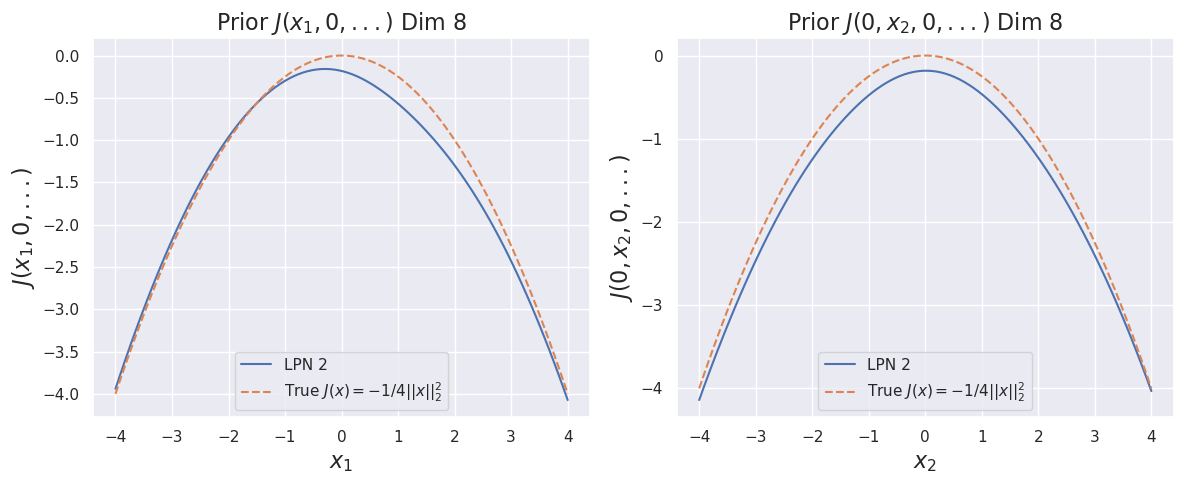

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)